## DNN

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import random
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from timm.models.layers import trunc_normal_

### Load Dataset

In [3]:
dataset = read_csv('clear_nj.csv')
index   = read_csv('index.csv').values
time    = dataset.values[:64,1:97].astype('float32') 
power   = dataset.values[:64,-7:-4].astype('float32')
week    = np.expand_dims(dataset.values[:64,-4], axis=-1).astype('float32') #week只有一个数 扩充维度
temp    = dataset.values[:64,-3:].astype('float32')

# normalize features
#归一化;归一化通常有两种：最值归一化和均值方差归一化，这里采用最值归一化
scaler1 = MinMaxScaler(feature_range=(0.1, 0.9)).fit(time) # 训练出一个适合time的归一化方法
scaler2 = MinMaxScaler(feature_range=(0.1, 0.9)).fit(power) #
scaler3 = MinMaxScaler(feature_range=(0.1, 1)).fit(week) #
scaler4 = MinMaxScaler(feature_range=(0.1, 0.9)).fit(temp) #
# scaler1 = StandardScaler().fit(time) #最大最小值归一化
# scaler2 = StandardScaler().fit(power) #最大最小值归一化
# scaler3 = StandardScaler().fit(temp) #最大最小值归一化

scaled_time = scaler1.fit_transform(time) #使用训练好的归一化方法
scaled_pow  = scaler2.fit_transform(power)#
scaled_week = scaler2.fit_transform(week) #
scaled_temp = scaler3.fit_transform(temp) #

print(time[0,:], '\n', time[-1,:]) #print出来看看有没有错
print(power[0,:],'\n', power[-1,:])
print(week[0,:],' \n', week[-1,:])
print(temp[0,:], '\n', temp[-1,:])

[1392.111  1431.4233 1423.0066 1410.7123 1372.748  1386.267  1381.3723
 1378.4746 1353.293  1335.6223 1320.3523 1333.945  1330.4126 1339.6173
 1313.3643 1301.4497 1296.531  1299.255  1305.5079 1317.6346 1315.7377
 1339.5693 1361.6046 1400.4777 1428.1663 1446.1556 1466.024  1468.502
 1481.8534 1496.226  1527.27   1571.114  1624.5447 1671.1204 1719.1327
 1754.1787 1798.2473 1819.5096 1848.9707 1861.4313 1885.8729 1900.818
 1932.3964 1942.5647 1938.48   1895.8207 1834.9507 1790.488  1764.1803
 1769.1963 1778.1836 1788.3136 1805.0197 1809.765  1815.3016 1811.8053
 1816.3494 1821.587  1815.79   1808.665  1808.1364 1822.047  1845.4183
 1864.1094 1880.1893 1881.735  1893.3247 1903.36   1933.1036 1961.5393
 1998.0183 2023.2023 2027.2847 2009.187  1989.5627 1970.744  1982.5453
 1994.414  2010.9124 1976.8947 1940.9207 1897.5177 1898.53   1895.3646
 1893.88   1858.2617 1831.558  1801.2733 1768.919  1718.2664 1669.4626
 1633.112  1615.0703 1596.0057 1562.915  1501.415 ] 
 [1710.195  1691.14   1683

In [4]:
def datamap(time, power, week, temp, index): #数据映射   每十五分钟负荷和每日最大最小平均负荷要用到其他天的
    seq = np.array([])  #建立一个空数组 拼成一行
    for i in range(time.shape[0]): #shape 0行 1列
        seq = np.concatenate((seq, time[i,:]), axis=0) 
    
    seq_pow = np.array([])
    for i in range(power.shape[0]):
        seq_pow = np.concatenate((seq_pow, power[i,:]), axis=0)
    
    total_x = []
    total_y = []    
    for m in range(1,5473):
        pow_index = [] #时序输入列表
        for indx in index:   #118个
            pow_index.append(np.squeeze(seq[-(m+indx)], axis=0)) #np.squeeze维度挤压     把需要的时刻索引添加到时序输入列表
        #每个点的最终输入:118个时序输入 七天的最大最小平均负荷输入 该时刻所在工作日   该时刻的最高最低平均温度
        total_x.append(np.concatenate((pow_index, seq_pow[-int((m//96)+24): -(int(m//96)+3)], week[-int(m//96)], temp[-int(m//96),:]), axis=0))
        total_y.append(seq[-m])  #最终的输出
        
    return total_x, total_y #total_x:  (:118)功率时间序列      (118:-4)功率最大最小均值    -4星期几        (-3:) 温度 

In [5]:
total_x, total_y = datamap(scaled_time, scaled_pow, scaled_week, scaled_temp, index)#调用函数

### 划分数据集

In [6]:
indx1  = int(math.floor(0.8*len(total_x)))
indx2  = int(indx1+math.floor(0.1*len(total_x)))
# random_indx = int(math.floor(random.randint(0, indx2))) # SOTA = 1324
random_indx = 1324

test_x = np.array(total_x[random_indx: random_indx+(indx2-indx1)]).astype('float32')        #测试集
test_y = np.array(total_y[random_indx: random_indx+(indx2-indx1)]).astype('float32')

res_x  = total_x[:random_indx] + total_x[random_indx+(indx2-indx1):]
res_y  = total_y[:random_indx] + total_y[random_indx+(indx2-indx1):]

seed = 1234
random.seed(seed)
random.shuffle(res_x)
random.seed(seed)
random.shuffle(res_y)   #随机划分避免模型过拟合，让数据分布更加均匀

train_x = np.array(res_x[: indx1]).astype('float32')       #训练集
train_y = np.array(res_y[: indx1]).astype('float32')
val_x   = np.array(res_x[indx1: ]).astype('float32')    #验证集
val_y   = np.array(res_y[indx1: ]).astype('float32')

print(train_x.shape, val_x.shape, test_x.shape, random_indx, random_indx+(indx2-indx1))

(4377, 143) (548, 143) (547, 143) 1324 1871


### Build Model

In [16]:
class dual_model(nn.Module): #双流模型
    def __init__(self):      #参数初始化
        super(dual_model, self).__init__() #定义一个超类 语法
        self.bn1   = nn.BatchNorm1d(128)
        self.bn2   = nn.BatchNorm1d(128)
        self.bn3   = nn.BatchNorm1d(128)
        self.bn4   = nn.BatchNorm1d(128)
        self.bn5   = nn.BatchNorm1d(128)
        self.bn6   = nn.BatchNorm1d(128)
        self.bn7   = nn.BatchNorm1d(128)
  
        self.d11   = nn.Linear(16, 128) #时序 0-16 先用mlp 映射到feature space 特征空间
        self.d12   = nn.Linear(16, 128) #时序 16-32
        self.d13   = nn.Linear(17, 128) #时序 
        self.d14   = nn.Linear(17, 128) #时序 
        self.d15   = nn.Linear(17, 128) #时序 
        self.d16   = nn.Linear(18, 128) #时序 
        self.d17   = nn.Linear(17, 128) #时序 
        
        self.c11   = nn.Conv1d(1, 1, 3, padding =1) 
        self.c12   = nn.Conv1d(1, 1, 3, padding =1) 
        self.c13   = nn.Conv1d(1, 1, 3, padding =1)
        self.c14   = nn.Conv1d(1, 1, 3, padding =1) 
        self.c15   = nn.Conv1d(1, 1, 3, padding =1)
        self.c16   = nn.Conv1d(1, 1, 3, padding =1)
        self.c17   = nn.Conv1d(1, 1, 3, padding =1) 
        
        self.LSTM1 = nn.LSTM(128, 128, 3, batch_first=True) #时序 通道batch是第一个维度   64个输入 64个输出  一层有64个lstm cell 只有一层
        self.LSTM2 = nn.LSTM(128, 128, 3, batch_first=True) #时序 通道batch是第一个维度   利用可学习的参数对7个lstm的输出进行加权平均
        self.LSTM3 = nn.LSTM(128, 128, 3, batch_first=True) #时序 通道batch是第一个维度
        self.LSTM4 = nn.LSTM(128, 128, 3, batch_first=True) #时序 通道batch是第一个维度
        self.LSTM5 = nn.LSTM(128, 128, 3, batch_first=True) #时序 通道batch是第一个维度
        self.LSTM6 = nn.LSTM(128, 128, 3, batch_first=True) #时序 通道batch是第一个维度
        self.LSTM7 = nn.LSTM(128, 128, 3, batch_first=True) #时序 通道batch是第一个维度

        self.d2   = nn.Linear(21, 64) #最大最小平均功率  mlp全连接层 映射到feature space 特征空间
        self.d3   = nn.Linear(1, 16) #工作日
        self.d4   = nn.Linear(3, 48) #天气
        self.d5   = nn.Linear(128, 128) #非时序信息融合交换
        self.d6   = nn.Linear(128, 1) #时序非时许融合到一个输出
        
        self.dw   = nn.Parameter(torch.randn(1, 7, dtype=torch.float32)) #生成7个可学习的权重
        trunc_normal_(self.dw, std=.02)    #方差为0.02的高斯初始化
        self.softmax = nn.Softmax(dim=-1)  #限制7个权重和为1
        self.relu = nn.LeakyReLU()         #Relu 激活函数 模型的输出限制0-1 
        # self.tanh = nn.Tanh() #Relu 激活函数 模型的输出限制0-1 
        # self.drop = nn.Dropout(p=0.2)
            
    def forward(self, x1, x2, x3, x4): #前向过程  全局变量 x1:118个时序输入 x2:七天的最大最小平均负荷输入 x3:该时刻所在工作日   x4:该时刻的最高最低平均温度
        x11   = self.relu(self.c11(self.relu(self.bn1(self.d11(x1[:,:16]))).unsqueeze(1)))    #激活
        x12   = self.relu(self.c12(self.relu(self.bn2(self.d12(x1[:,16:32]))).unsqueeze(1)))
        x13   = self.relu(self.c13(self.relu(self.bn3(self.d13(x1[:,32:49]))).unsqueeze(1)))
        x14   = self.relu(self.c14(self.relu(self.bn4(self.d14(x1[:,49:66]))).unsqueeze(1)))
        x15   = self.relu(self.c15(self.relu(self.bn5(self.d15(x1[:,66:83]))).unsqueeze(1)))
        x16   = self.relu(self.c16(self.relu(self.bn6(self.d16(x1[:,83:101]))).unsqueeze(1)))
        x17   = self.relu(self.c17(self.relu(self.bn7(self.d17(x1[:,101:]))).unsqueeze(1)))
   
        info1, (hn1, cn1) = self.LSTM1(x11) #info:lstm输出
        info2, (hn2, cn2) = self.LSTM2(x12) 
        info3, (hn3, cn3) = self.LSTM3(x13) 
        info4, (hn4, cn4) = self.LSTM4(x14) 
        info5, (hn5, cn5) = self.LSTM5(x15) 
        info6, (hn6, cn6) = self.LSTM6(x16) 
        info7, (hn7, cn7) = self.LSTM7(x17) 
        
        info = torch.cat((info1.unsqueeze(0).reshape(1, -1),info2.unsqueeze(0).reshape(1, -1),info3.unsqueeze(0).reshape(1, -1), \
                          info4.unsqueeze(0).reshape(1, -1),info5.unsqueeze(0).reshape(1, -1),info6.unsqueeze(0).reshape(1, -1), \
                          info7.unsqueeze(0).reshape(1, -1)), dim=0) #7个输出（256*64）拼成一列   torch.cat
        
        info = torch.mm(self.softmax(self.dw), info).reshape(-1, 128)  #torch.mm矩阵乘法  利用可学习的参数对7个lstm的输出进行加权平均 最终得到256*64的输出
        
        x2 = self.relu(self.d2(x2))
        x3 = self.relu(self.d3(x3))
        x4 = self.relu(self.d4(x4))
        no_seq = self.relu(self.d5(torch.cat([x2, x3, x4], dim=1))) #dim = [Batch, ] dim = [0, 1, 2]
        
        fuse = torch.add(info, no_seq) #将非时序信息与时序信息融合 逐元素相加 torch.add矩阵加法
        
        return self.relu(self.d6(fuse))#融合之后再经历一次线性层输出后relu函数激活

In [17]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = dual_model().cuda() #模型
        self.loss  = nn.L1Loss()         #绝对值损失 mae
        # self.loss  = nn.SmoothL1Loss()
        self.batch = 512                 #一次喂多少个数据给模型
        self.opt   = torch.optim.Adam(self.model.parameters(), lr=2e-5, weight_decay = 2e-5)    #定义一个adam优化器 参数：学习率、梯度衰减  
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size = 150, gamma=0.99) #每150个epoch学习率衰减到原来的0.99
        self.epochs    = 2500 #训练轮数
        self.train_loss= []   #训练损失 为损失函数可视化准备
        self.eval_loss = []   #测试损失
        
    def fit(self, train_x, train_y, test_x, test_y, save_path='save2/'):
        for epoch in tqdm(range(self.epochs)): #可视化进度条
            batch_loss = []                    #一个batch的损失
            self.model.train() 
            lr = self.opt.param_groups[0]['lr']
            for i in range(0, len(train_x), self.batch):
                x1 = torch.tensor(train_x[i:i+self.batch, :118]).cuda()              #时序信息（7天）
                x2 = torch.tensor(train_x[i:i+self.batch, 118:-4]).cuda()            #最大最小平均功率
                x3 = torch.tensor(train_x[i:i+self.batch, -4]).unsqueeze(-1).cuda()  #星期几
                x4 = torch.tensor(train_x[i:i+self.batch, -3:]).cuda()               #最高最低平均温度
                y  = torch.tensor(train_y[i:i+self.batch]).unsqueeze(-1).cuda()      #Label（真实的负荷）; unsqueeze: 维度扩充
                pred = self.model(x1, x2, x3, x4)       #模型前向
                loss = self.loss(pred, y)               #计算loss
                loss.backward()                         #反向传播
                self.opt.step()                         #优化 更新模型参数
                self.scheduler.step()                   #更新学习率
                loss = loss.detach().cpu()              #detach:截断梯度，cpu:把数据从gpu放到cpu，方便绘图
                batch_loss.append(loss)                 #把loss放到列表中，方便后续可视化训练过程
                  
            if epoch%100==0:      
               
                self.save_params(save_path+str(epoch)+'.model')
                print(lr, sum(batch_loss)/len(batch_loss))         #平均batch损失
                eval_x = test_x 
                eval_y = torch.tensor(test_y).unsqueeze(-1).cuda() #将y 从np里的数组转为张量 pytorch框架只能对张量计算
                pred = self.pred(eval_x)
                loss = self.loss(pred.squeeze(0), eval_y).detach().cpu()  
                
                self.train_loss.append(sum(batch_loss)/len(batch_loss))
                self.eval_loss.append(loss)     
        
        return self.train_loss, self.eval_loss #每一百轮的损失函数  列表
     

    def pred(self, test_x):  #预测
        self.model.eval()
        with torch.no_grad():
            x1 = torch.tensor(test_x[:,:118]).cuda()
            x2 = torch.tensor(test_x[:,118:-4]).cuda()
            x3 = torch.tensor(test_x[:,-4]).unsqueeze(-1).cuda()
            x4 = torch.tensor(test_x[:,-3:]).cuda()
            pred = self.model(x1, x2, x3, x4)
        return pred
    
    
    def evaluate(self, test_x, test_y, time1, time2): #评估模型 
        self.model.eval()
        eval_loss = []
        x1 = torch.tensor(test_x[:, :118]).cuda()
        x2 = torch.tensor(test_x[:, 118:-4]).cuda()
        x3 = torch.tensor(test_x[:, -4]).unsqueeze(-1).cuda()  
        x4 = torch.tensor(test_x[:, -3:]).cuda()  
        y  = torch.tensor(test_y).unsqueeze(-1).cuda()
        pred = self.model(x1, x2, x3, x4)
        loss = abs(pred-y) #计算预测值与真实值之间的差距
        #.mean()    
        # loss = self.loss(pred, y).detach().cpu()  
        # print(loss)
        # print(y.mean())
    
        for i in range(loss.shape[0]):  
            eval_loss.append(loss[i].item()/y[i].item())    #计算误差占真实值y的百分之多少
            
#         # print(eval_loss)
#         perc = (sum(eval_loss)/len(eval_loss))/(sum(test_y)/len(test_y))*100 
        perc = (sum(eval_loss)/len(eval_loss))*100          #平均百分比误差 

        print('Percentage error is :', perc)
        
        fig = plt.figure(figsize=(4,3), dpi=320)
        plt.plot(y.squeeze(0).detach().cpu().numpy()[time1:time2], color='b', label='eval_loss', linewidth=0.8)     #真实
        plt.plot(pred.squeeze(0).detach().cpu().numpy()[time1:time2], color='r', label='train_loss', linewidth=0.8) #
        plt.show()
        fig.savefig('NN_pred.pdf')
        
        return pred, loss
        
        
    def save_params(self, path):   #保存模型参数
        torch.save(self.state_dict(), path)
    
    def load_params(self, path):   #读取模型参数
        self_state = self.state_dict()
        loaded_state = torch.load(path)
        for name, param in loaded_state.items():
            origname = name
            if name not in self_state:
                name = name.replace("module.", "")
                if name not in self_state:
                    print("%s is not in the model."%origname)
                    continue
            if self_state[name].size() != loaded_state[origname].size():
                print("Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()))
                continue
            self_state[name].copy_(param)           
          
    
# Create an instance of the model
model = MyModel().cuda()

### Fitting

In [8]:
train_loss, eval_loss = model.fit(train_x, train_y, val_x, val_y)

  0%|                                                                               | 1/2500 [00:01<1:05:00,  1.56s/it]

2e-05 tensor(0.4558)


  4%|███▏                                                                           | 101/2500 [00:24<09:15,  4.32it/s]

1.8829602988019998e-05 tensor(0.0846)


  8%|██████▎                                                                        | 201/2500 [00:46<08:58,  4.27it/s]

1.772769743432258e-05 tensor(0.0565)


 12%|█████████▌                                                                     | 301/2500 [01:08<08:15,  4.44it/s]

1.6690275229001744e-05 tensor(0.0507)


 16%|████████████▋                                                                  | 401/2500 [01:30<08:20,  4.19it/s]

1.571356281614437e-05 tensor(0.0358)


 20%|███████████████▊                                                               | 501/2500 [01:52<07:32,  4.42it/s]

1.4794007467765599e-05 tensor(0.0431)


 24%|██████████████████▉                                                            | 601/2500 [02:15<06:57,  4.54it/s]

1.3928264360991464e-05 tensor(0.0526)


 28%|██████████████████████▏                                                        | 701/2500 [02:37<06:53,  4.35it/s]

1.3113184411482866e-05 tensor(0.0518)


 32%|█████████████████████████▎                                                     | 801/2500 [02:59<06:18,  4.49it/s]

1.2345802818845753e-05 tensor(0.0443)


 36%|████████████████████████████▍                                                  | 901/2500 [03:21<05:56,  4.49it/s]

1.1623328282362185e-05 tensor(0.0429)


 40%|███████████████████████████████▏                                              | 1001/2500 [03:44<05:33,  4.49it/s]

1.0943132847815219e-05 tensor(0.0319)


 44%|██████████████████████████████████▎                                           | 1101/2500 [04:06<05:27,  4.27it/s]

1.0302742348476063e-05 tensor(0.0323)


 48%|█████████████████████████████████████▍                                        | 1201/2500 [04:28<04:46,  4.53it/s]

9.699827405483254e-06 tensor(0.0309)


 52%|████████████████████████████████████████▌                                     | 1301/2500 [04:50<04:29,  4.44it/s]

9.132194954878289e-06 tensor(0.0286)


 56%|███████████████████████████████████████████▋                                  | 1401/2500 [05:13<04:18,  4.25it/s]

8.597780270477869e-06 tensor(0.0301)


 60%|██████████████████████████████████████████████▊                               | 1501/2500 [05:35<04:01,  4.14it/s]

8.094639453566474e-06 tensor(0.0229)


 64%|█████████████████████████████████████████████████▉                            | 1601/2500 [05:57<03:30,  4.27it/s]

7.620942362090992e-06 tensor(0.0274)


 68%|█████████████████████████████████████████████████████                         | 1701/2500 [06:19<02:58,  4.48it/s]

7.1749659536378365e-06 tensor(0.0216)


 72%|████████████████████████████████████████████████████████▏                     | 1801/2500 [06:41<02:39,  4.39it/s]

6.755088017978038e-06 tensor(0.0234)


 76%|███████████████████████████████████████████████████████████▎                  | 1901/2500 [07:03<02:17,  4.36it/s]

6.359781276382869e-06 tensor(0.0200)


 80%|██████████████████████████████████████████████████████████████▍               | 2001/2500 [07:25<01:51,  4.47it/s]

5.987607826246625e-06 tensor(0.0206)


 84%|█████████████████████████████████████████████████████████████████▌            | 2101/2500 [07:47<01:29,  4.47it/s]

5.637213910809269e-06 tensor(0.0189)


 88%|████████████████████████████████████████████████████████████████████▋         | 2201/2500 [08:09<01:06,  4.50it/s]

5.307324994954105e-06 tensor(0.0184)


 92%|███████████████████████████████████████████████████████████████████████▊      | 2301/2500 [08:31<00:44,  4.48it/s]

4.996741129169053e-06 tensor(0.0174)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2401/2500 [08:54<00:22,  4.45it/s]

4.704332584808202e-06 tensor(0.0175)


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [09:16<00:00,  4.50it/s]


### Visualization

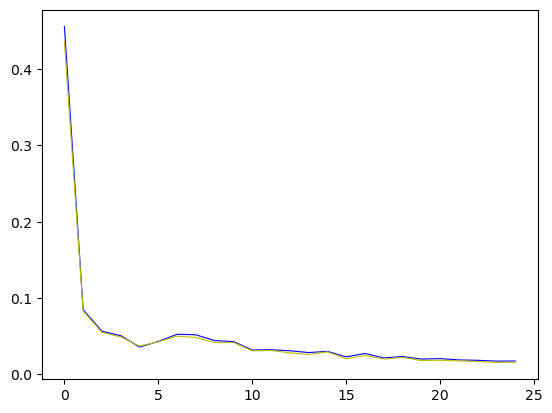

In [9]:
plt.plot(train_loss, color='b', label='train_loss', linewidth=0.8) #训练
plt.plot(eval_loss, color='y', label='eval_loss', linewidth=0.8)   #测试
plt.show()

### Evaluation

#### Neural Network

In [18]:
model.load_params('save_SOTA/2400.model')

Percentage error is : 3.080668962768523


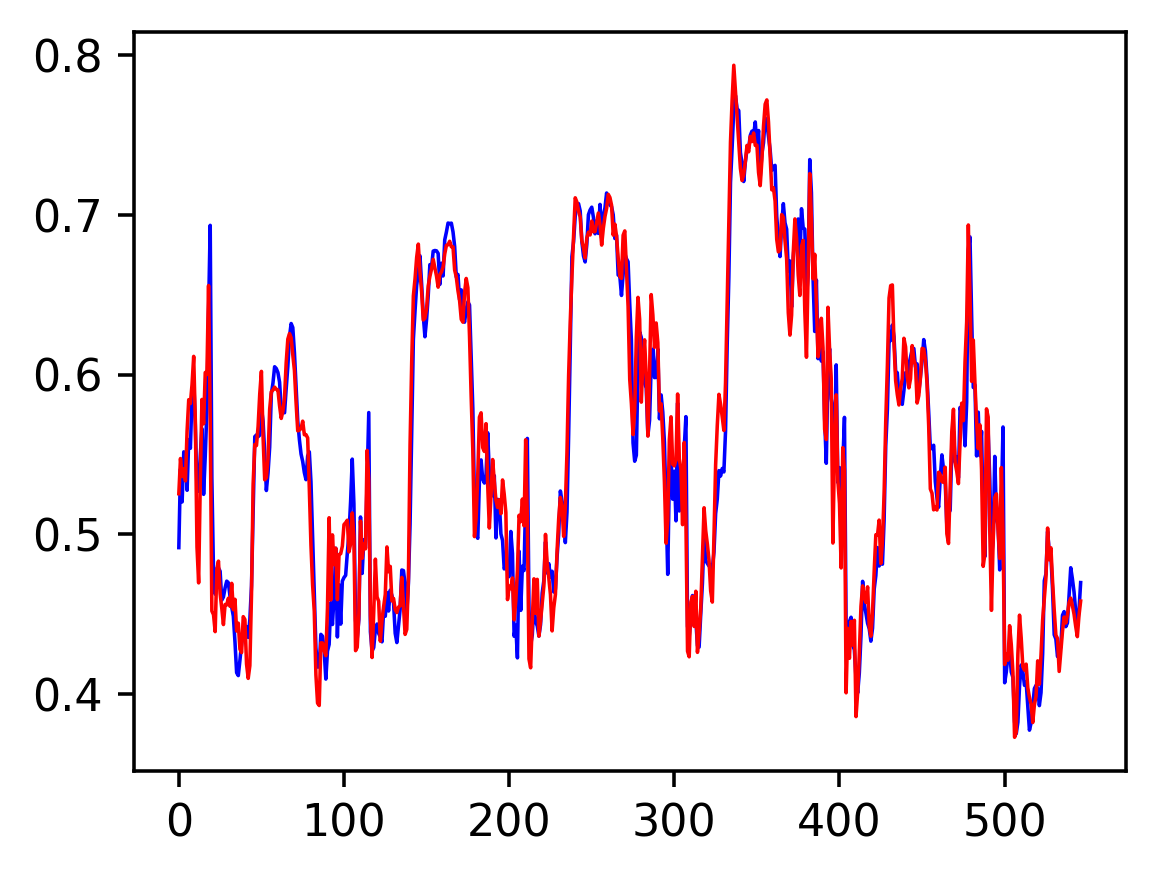

In [19]:
pred, loss = model.evaluate(test_x, test_y, 0, 547)

Percentage error is : 3.0579096136981723


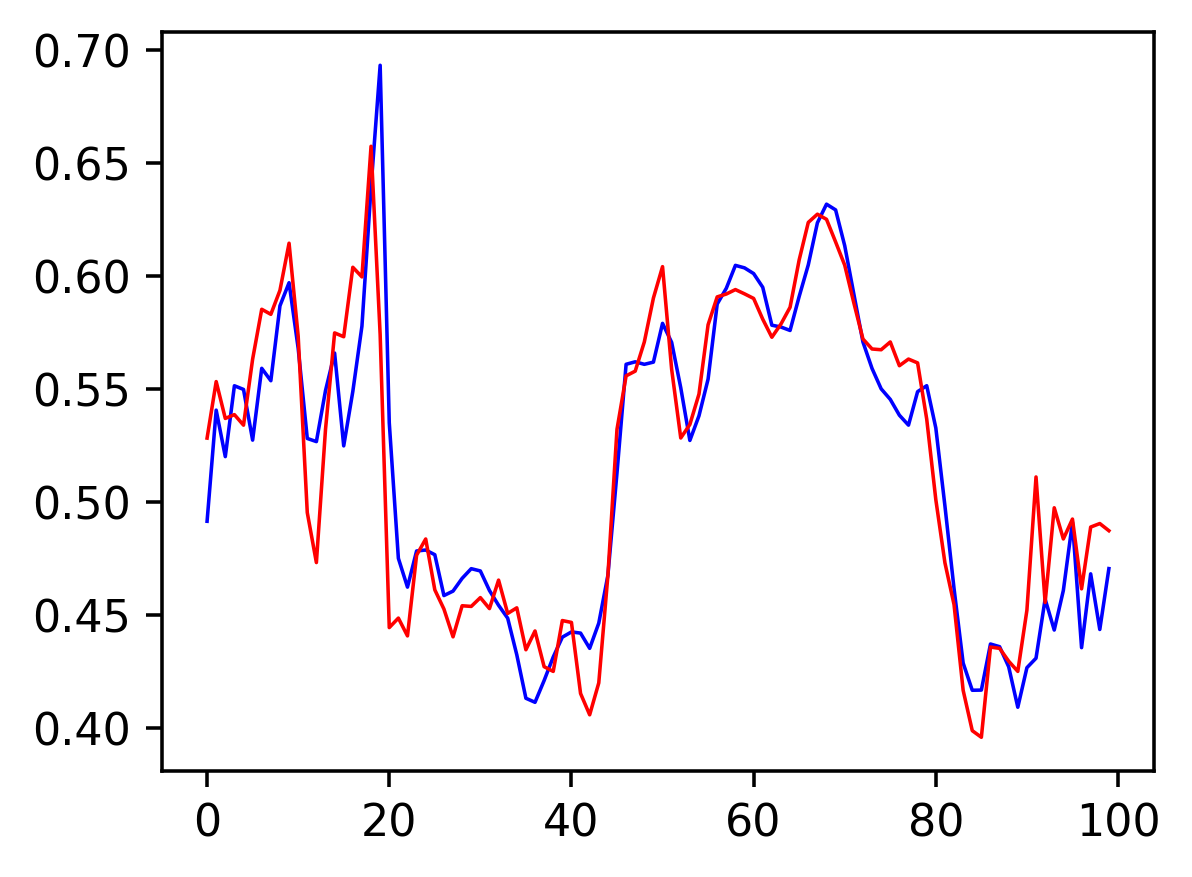

In [11]:
pred, loss = model.evaluate(test_x, test_y, 0, 100)

Percentage error is : 3.0579096136981723


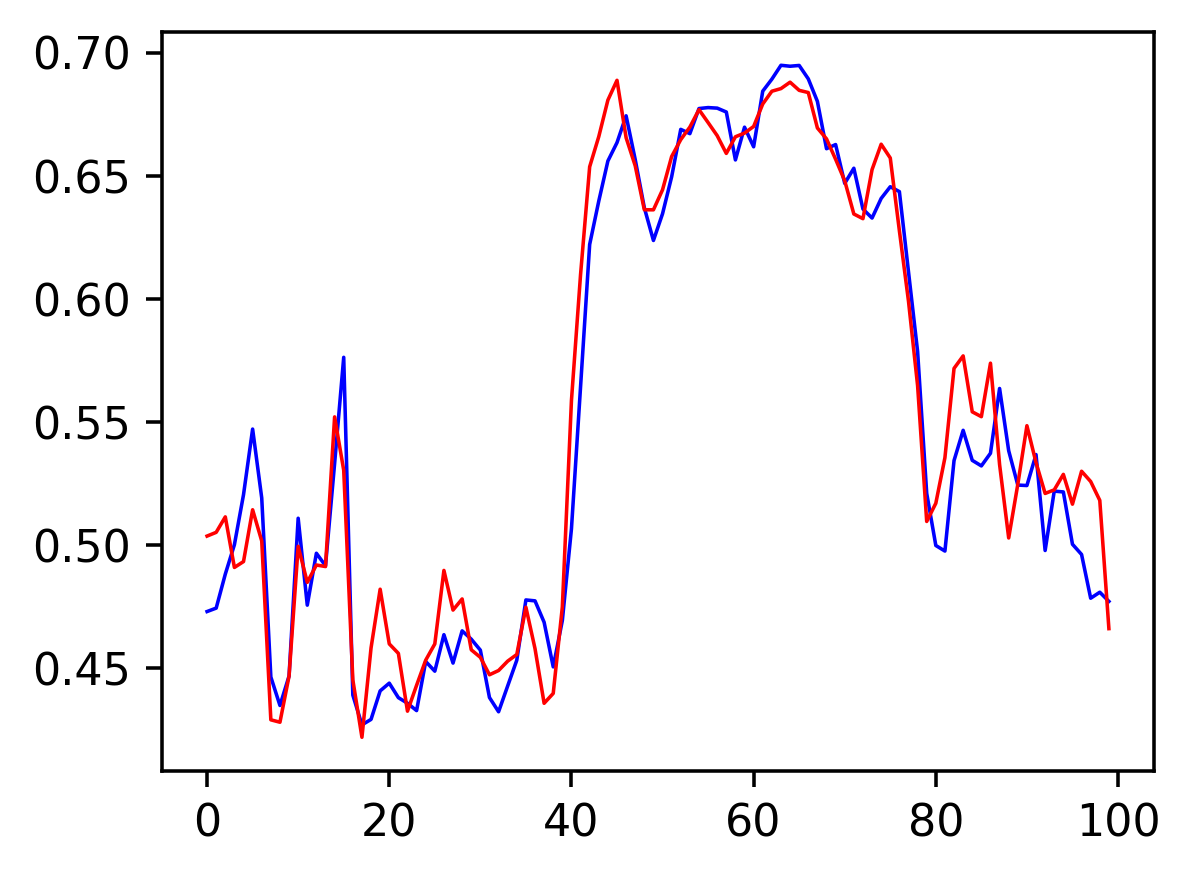

In [12]:
pred, loss = model.evaluate(test_x, test_y, 100, 200)

#### visual Dynamic weights

In [37]:
n_weights = F.softmax(model.model.dw, dim=-1)
n_weights

tensor([[0.1672, 0.1202, 0.1547, 0.1518, 0.1355, 0.1191, 0.1515]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

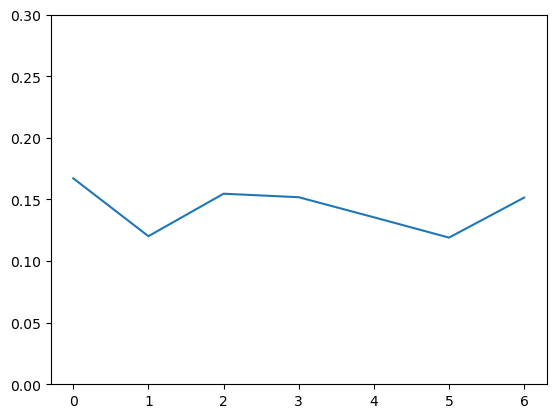

In [39]:
plt.ylim(0, 0.3)
plt.plot(n_weights.squeeze(0).detach().cpu().numpy())

## SVR

In [13]:
import numpy as np
import pandas as pd
import random
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# %matplotlib inline

Percentage error is : 5.56697950037554


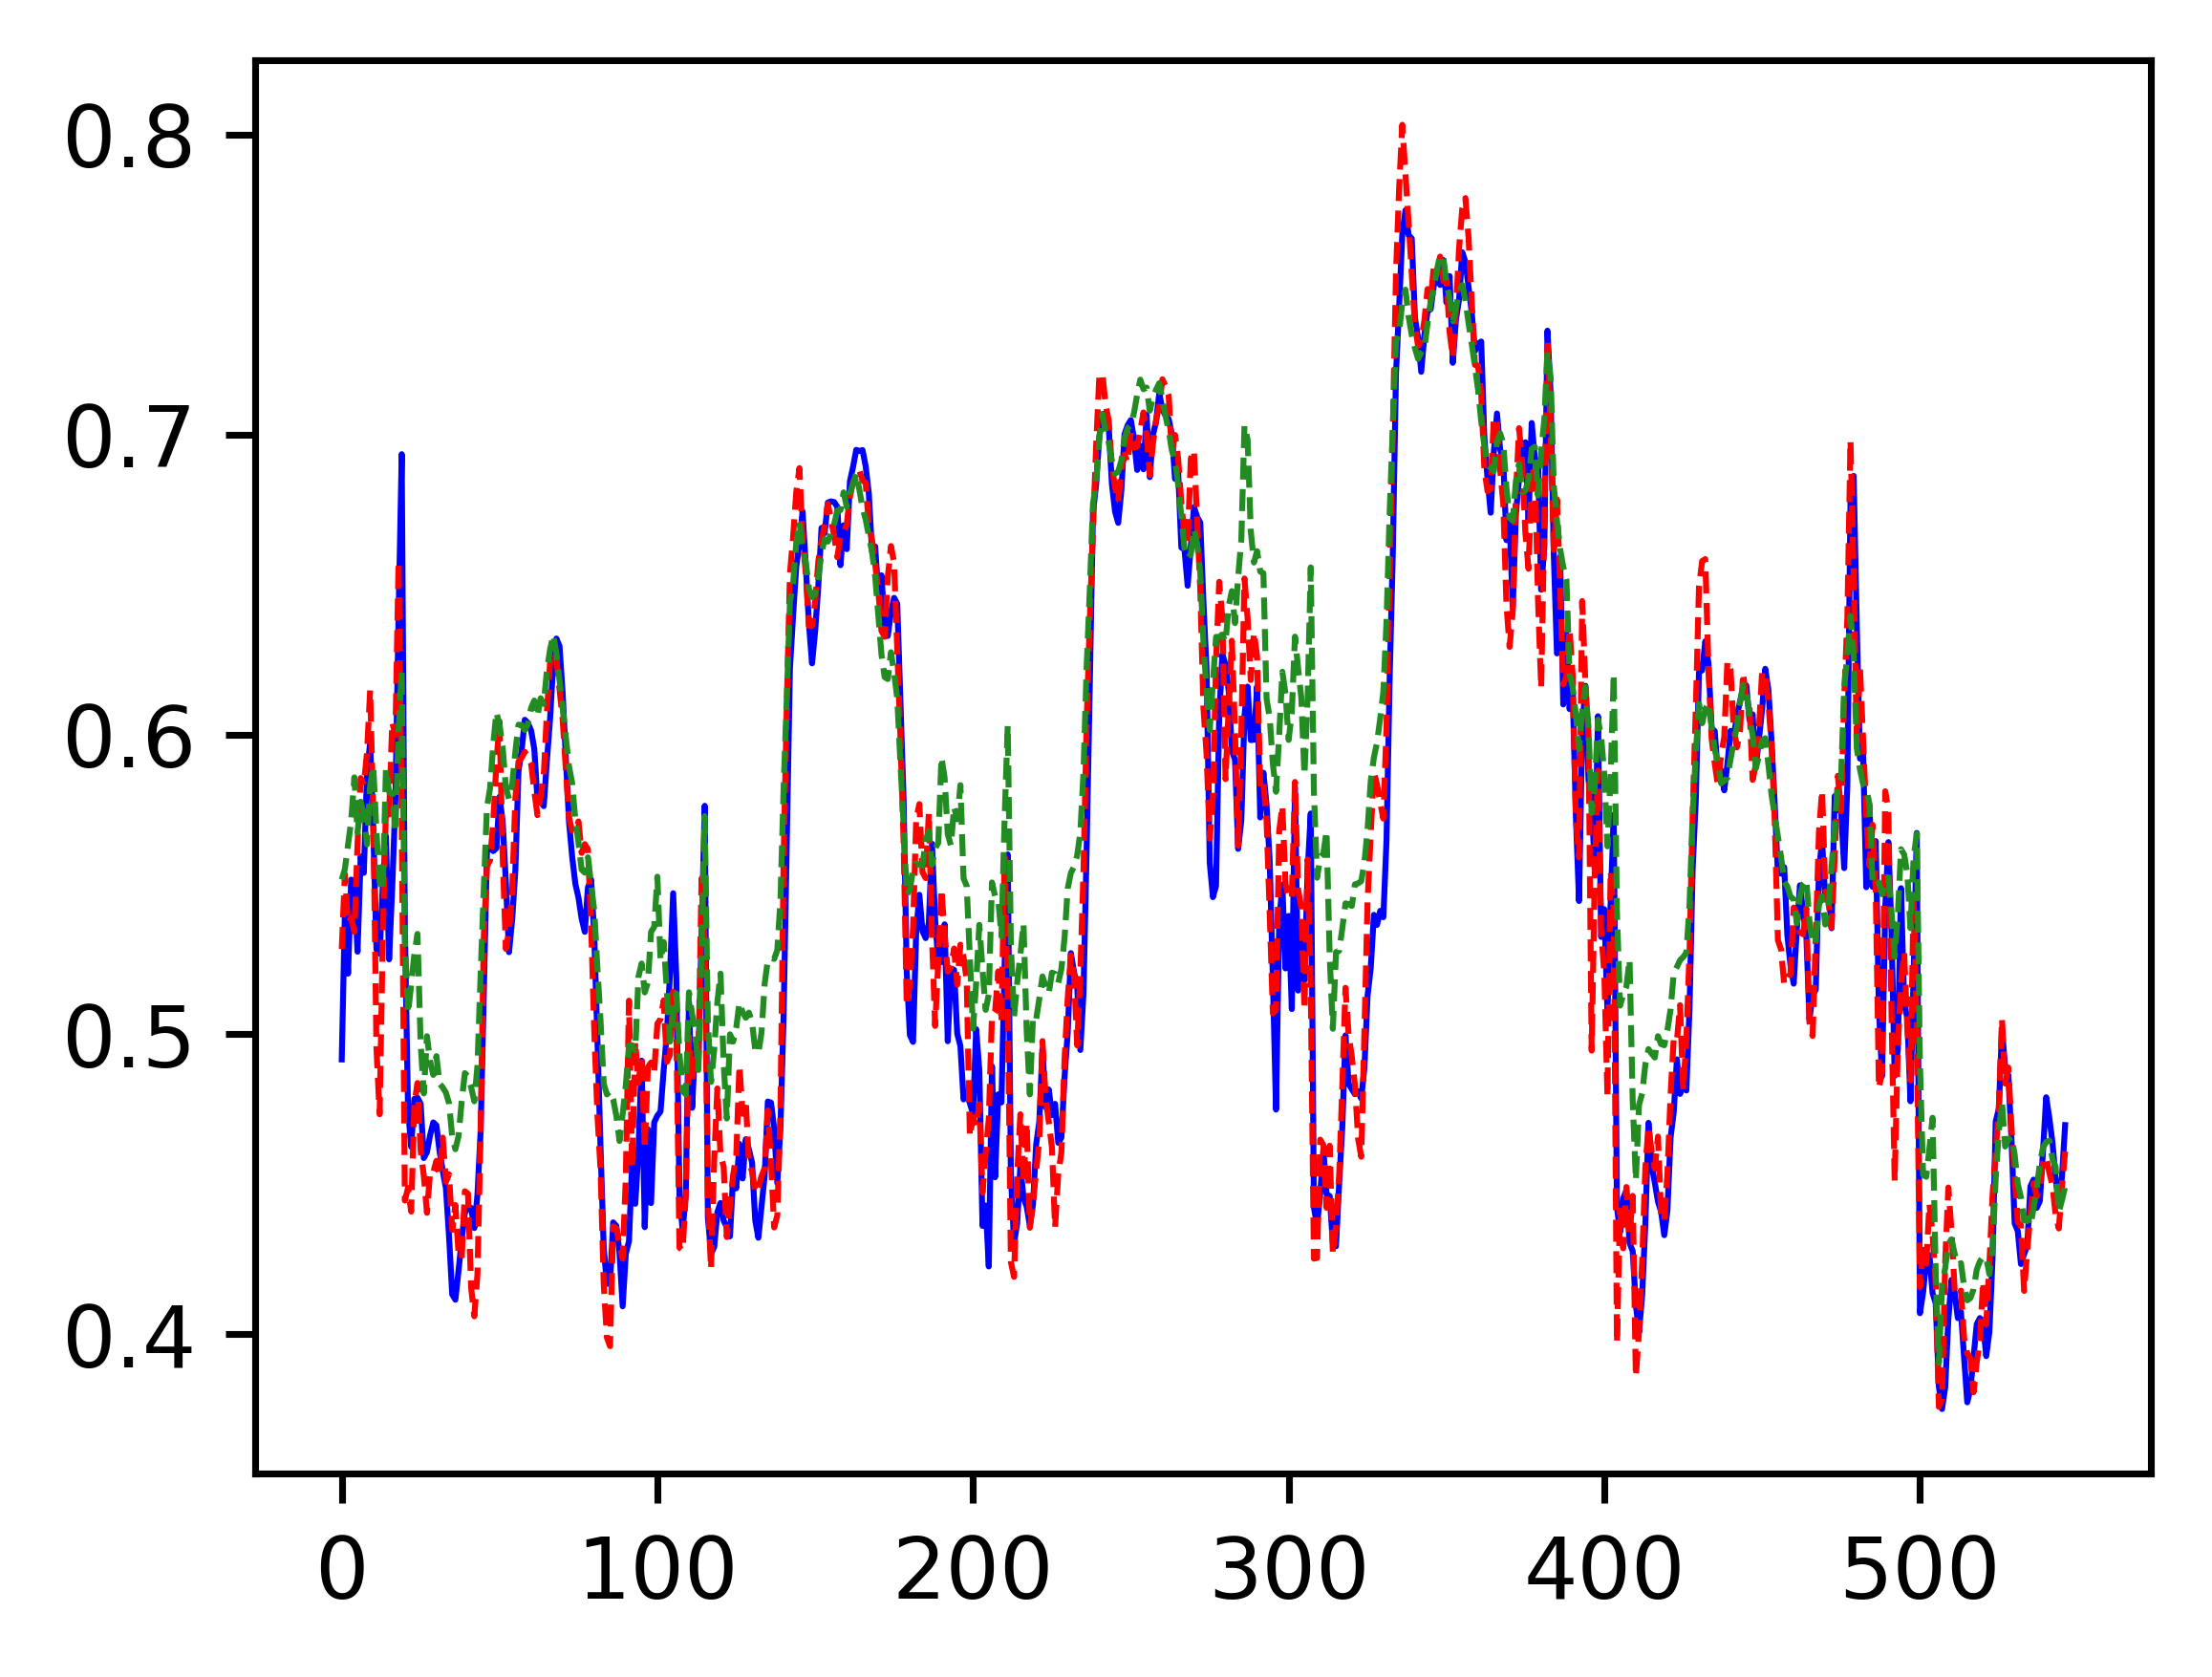

In [22]:
# 线性核函数配置支持向量机
svr = SVR(kernel="linear")
# 训练
svr.fit(train_x, train_y)
# 预测 保存预测结果
svr_y_predict = svr.predict(test_x)
pred_loss = svr_y_predict-test_y
eval_loss = []
for i in range(pred_loss.shape[0]):  
    eval_loss.append(pred_loss[i].item()/test_y[i].item())    #计算误差占真实值y的百分之多少
    
perc = (sum(eval_loss)/len(eval_loss))*100          #平均百分比误差 
print('Percentage error is :', perc)

fig = plt.figure(figsize=(4,3), dpi=640)
plt.plot(test_y, color='b', linewidth=0.7)
plt.plot(pred.squeeze(0).detach().cpu().numpy(), '--', color='r', linewidth=0.7)
plt.plot(svr_y_predict, '--', color='forestgreen', linewidth=0.7)
plt.show()
fig.savefig('./SVM_pred.pdf')

Percentage error is : 5.56697950037554


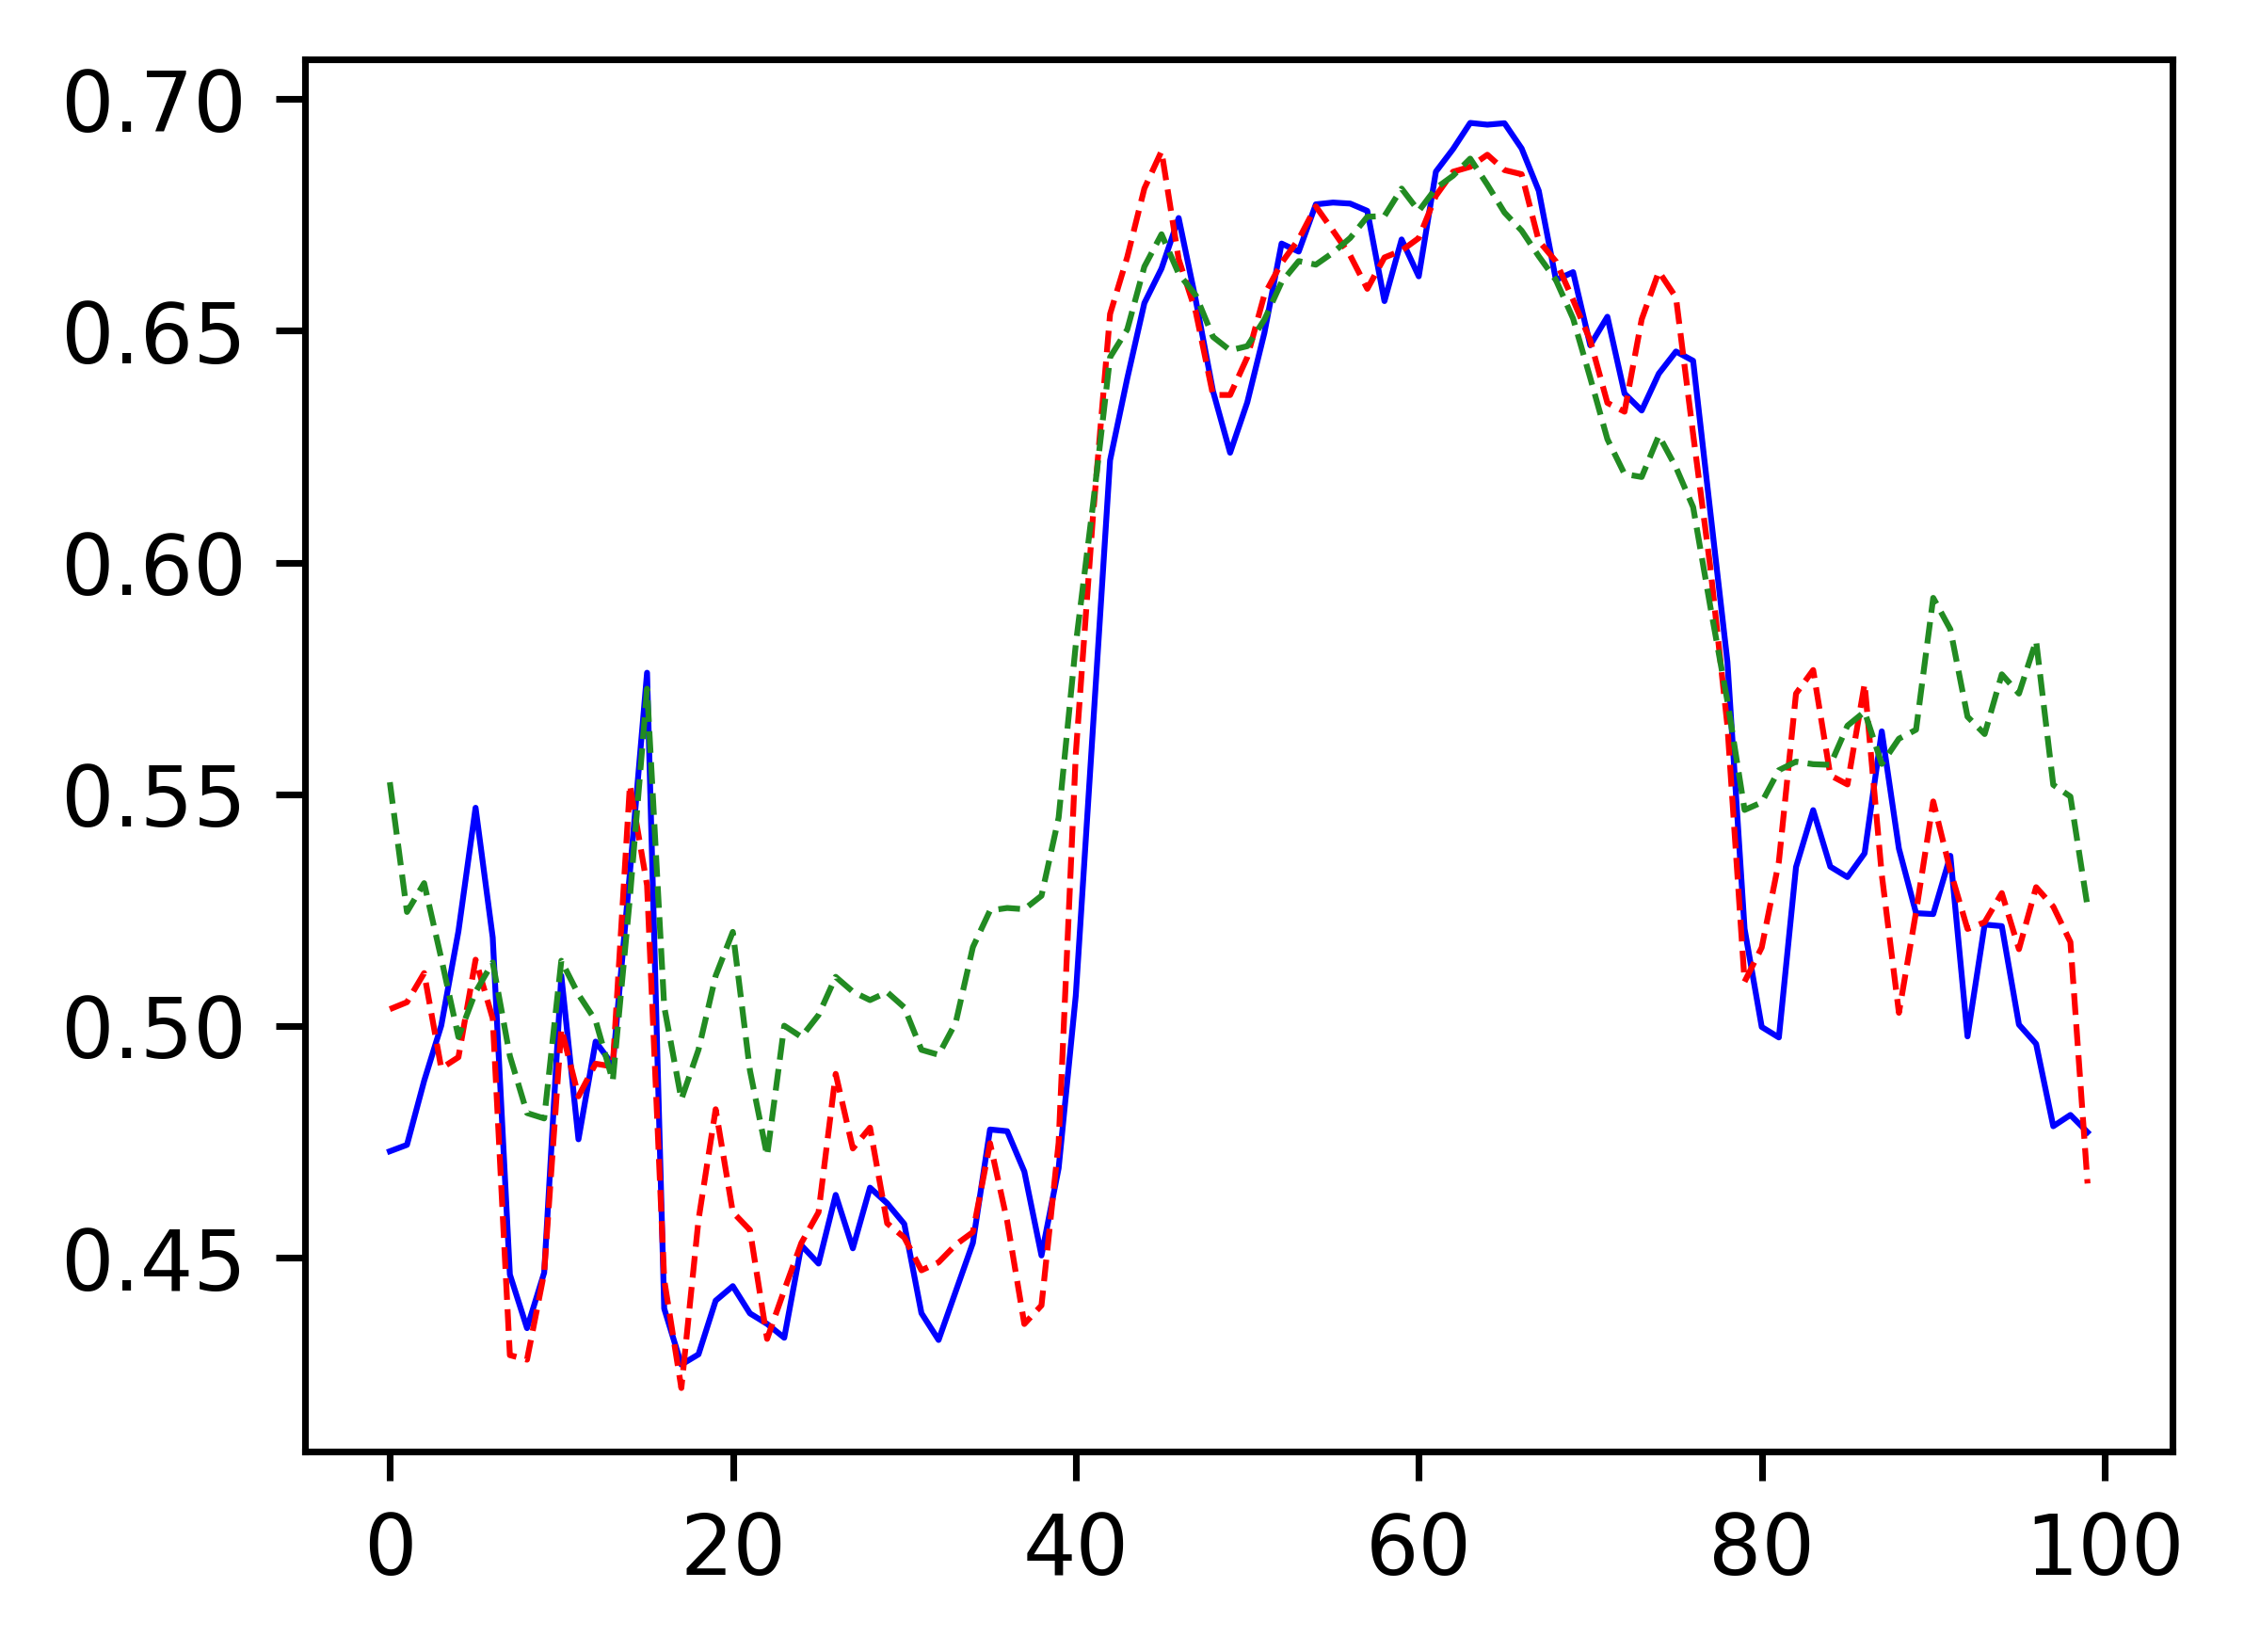

In [29]:
# 线性核函数配置支持向量机
svr = SVR(kernel="linear")
# 训练
svr.fit(train_x, train_y)
# 预测 保存预测结果
svr_y_predict = svr.predict(test_x)
pred_loss = svr_y_predict-test_y
eval_loss = []
for i in range(pred_loss.shape[0]):  
    eval_loss.append(pred_loss[i].item()/test_y[i].item())    #计算误差占真实值y的百分之多少
    
perc = (sum(eval_loss)/len(eval_loss))*100          #平均百分比误差 
print('Percentage error is :', perc)

fig = plt.figure(figsize=(4,3), dpi=640)
plt.plot(test_y[100: 200], color='b', linewidth=0.7)
plt.plot(pred.squeeze(0).detach().cpu().numpy()[100: 200], '--', color='r', linewidth=0.7)
plt.plot(svr_y_predict[100: 200], '--', color='forestgreen', linewidth=0.7)
plt.show()
fig.savefig('./SVM_pred.pdf')

Percentage error is : 5.56697950037554


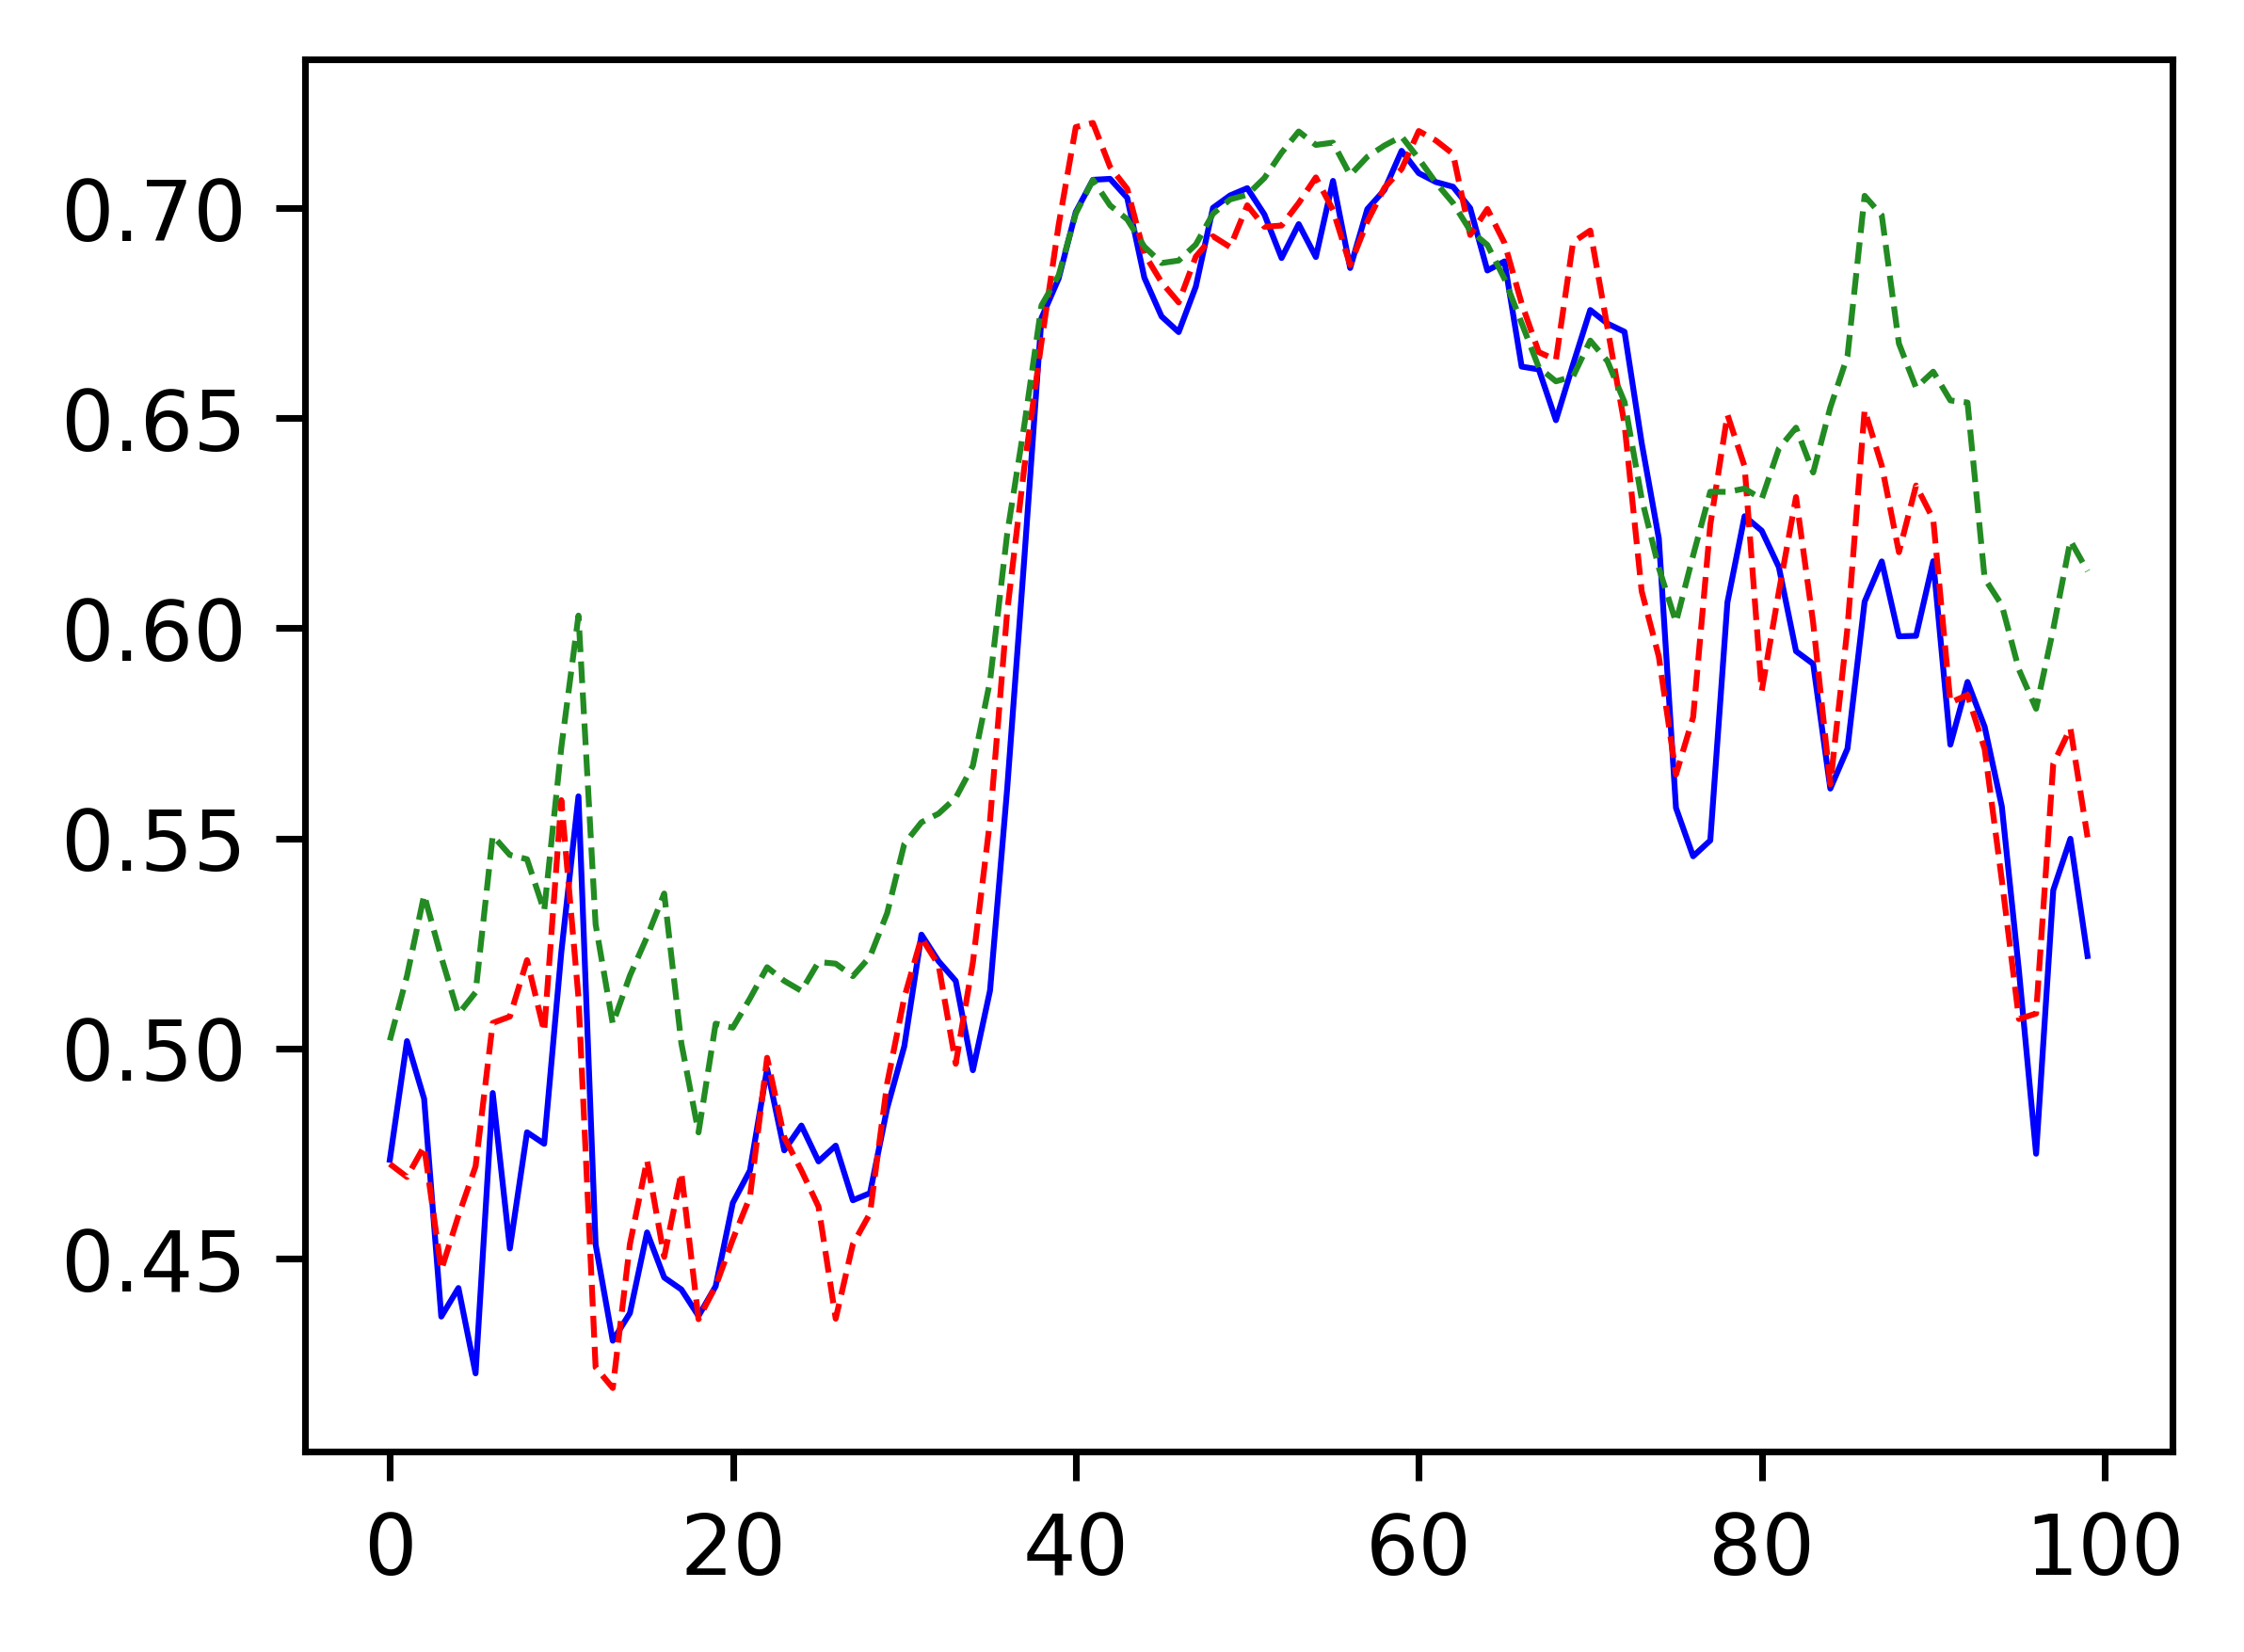

In [30]:
# 线性核函数配置支持向量机
svr = SVR(kernel="linear")
# 训练
svr.fit(train_x, train_y)
# 预测 保存预测结果
svr_y_predict = svr.predict(test_x)
pred_loss = svr_y_predict-test_y
eval_loss = []
for i in range(pred_loss.shape[0]):  
    eval_loss.append(pred_loss[i].item()/test_y[i].item())    #计算误差占真实值y的百分之多少
    
perc = (sum(eval_loss)/len(eval_loss))*100          #平均百分比误差 
print('Percentage error is :', perc)

fig = plt.figure(figsize=(4,3), dpi=640)
plt.plot(test_y[200: 300], color='b', linewidth=0.7)
plt.plot(pred.squeeze(0).detach().cpu().numpy()[200: 300], '--', color='r', linewidth=0.7)
plt.plot(svr_y_predict[200: 300], '--', color='forestgreen', linewidth=0.7)
plt.show()
fig.savefig('./SVM_pred_2030.pdf')

Percentage error is : 6.547682840676453


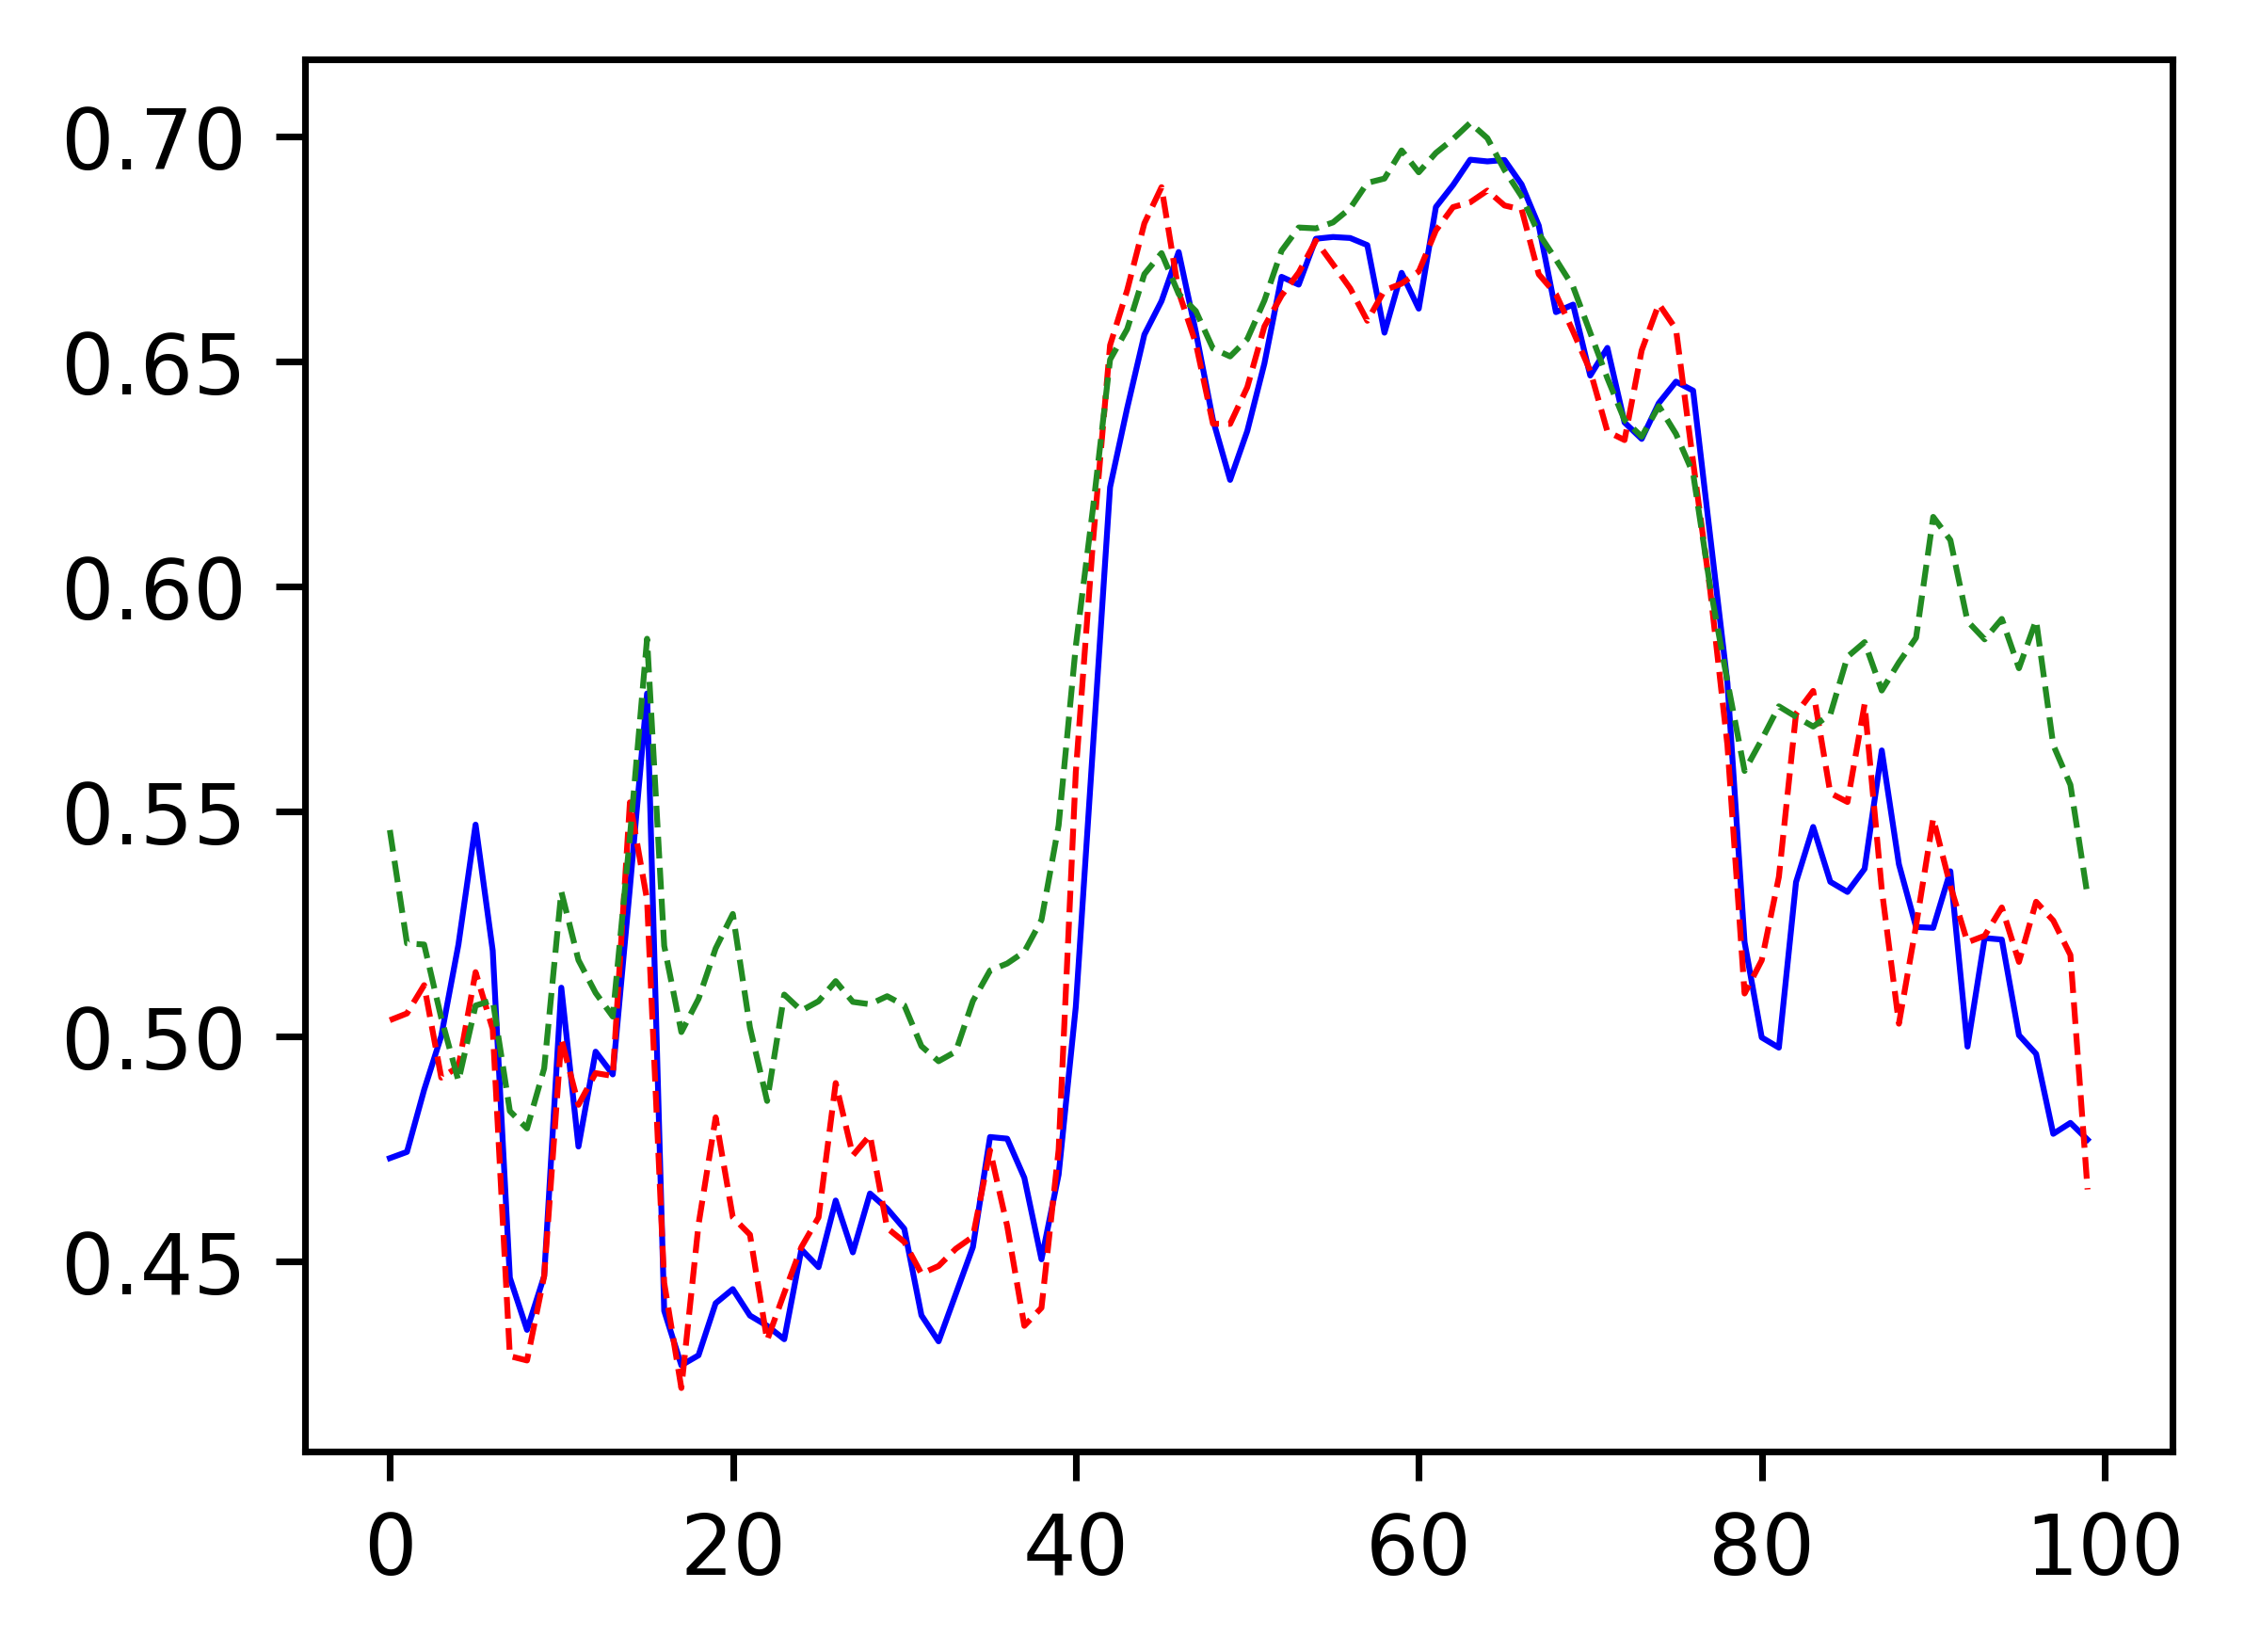

In [32]:
# 多项式核函数配置支持向量机
svr = SVR(kernel='poly', C=100, gamma='auto', degree=4, epsilon=.1, coef0=1)
# 训练
svr.fit(train_x, train_y)
# 预测 保存预测结果
svr_y_predict = svr.predict(test_x)
pred_loss = svr_y_predict-test_y
eval_loss = []
for i in range(pred_loss.shape[0]):  
    eval_loss.append(pred_loss[i].item()/test_y[i].item())    #计算误差占真实值y的百分之多少
    
perc = (sum(eval_loss)/len(eval_loss))*100          #平均百分比误差 
print('Percentage error is :', perc)

fig = plt.figure(figsize=(4,3), dpi=640)
plt.plot(test_y[100: 200], color='b', linewidth=0.7)
plt.plot(pred.squeeze(0).detach().cpu().numpy()[100: 200], '--', color='r', linewidth=0.7)
plt.plot(svr_y_predict[100: 200], '--', color='forestgreen', linewidth=0.7)
plt.show()
fig.savefig('./SVM_pred2.pdf')

Percentage error is : 4.918188848783746


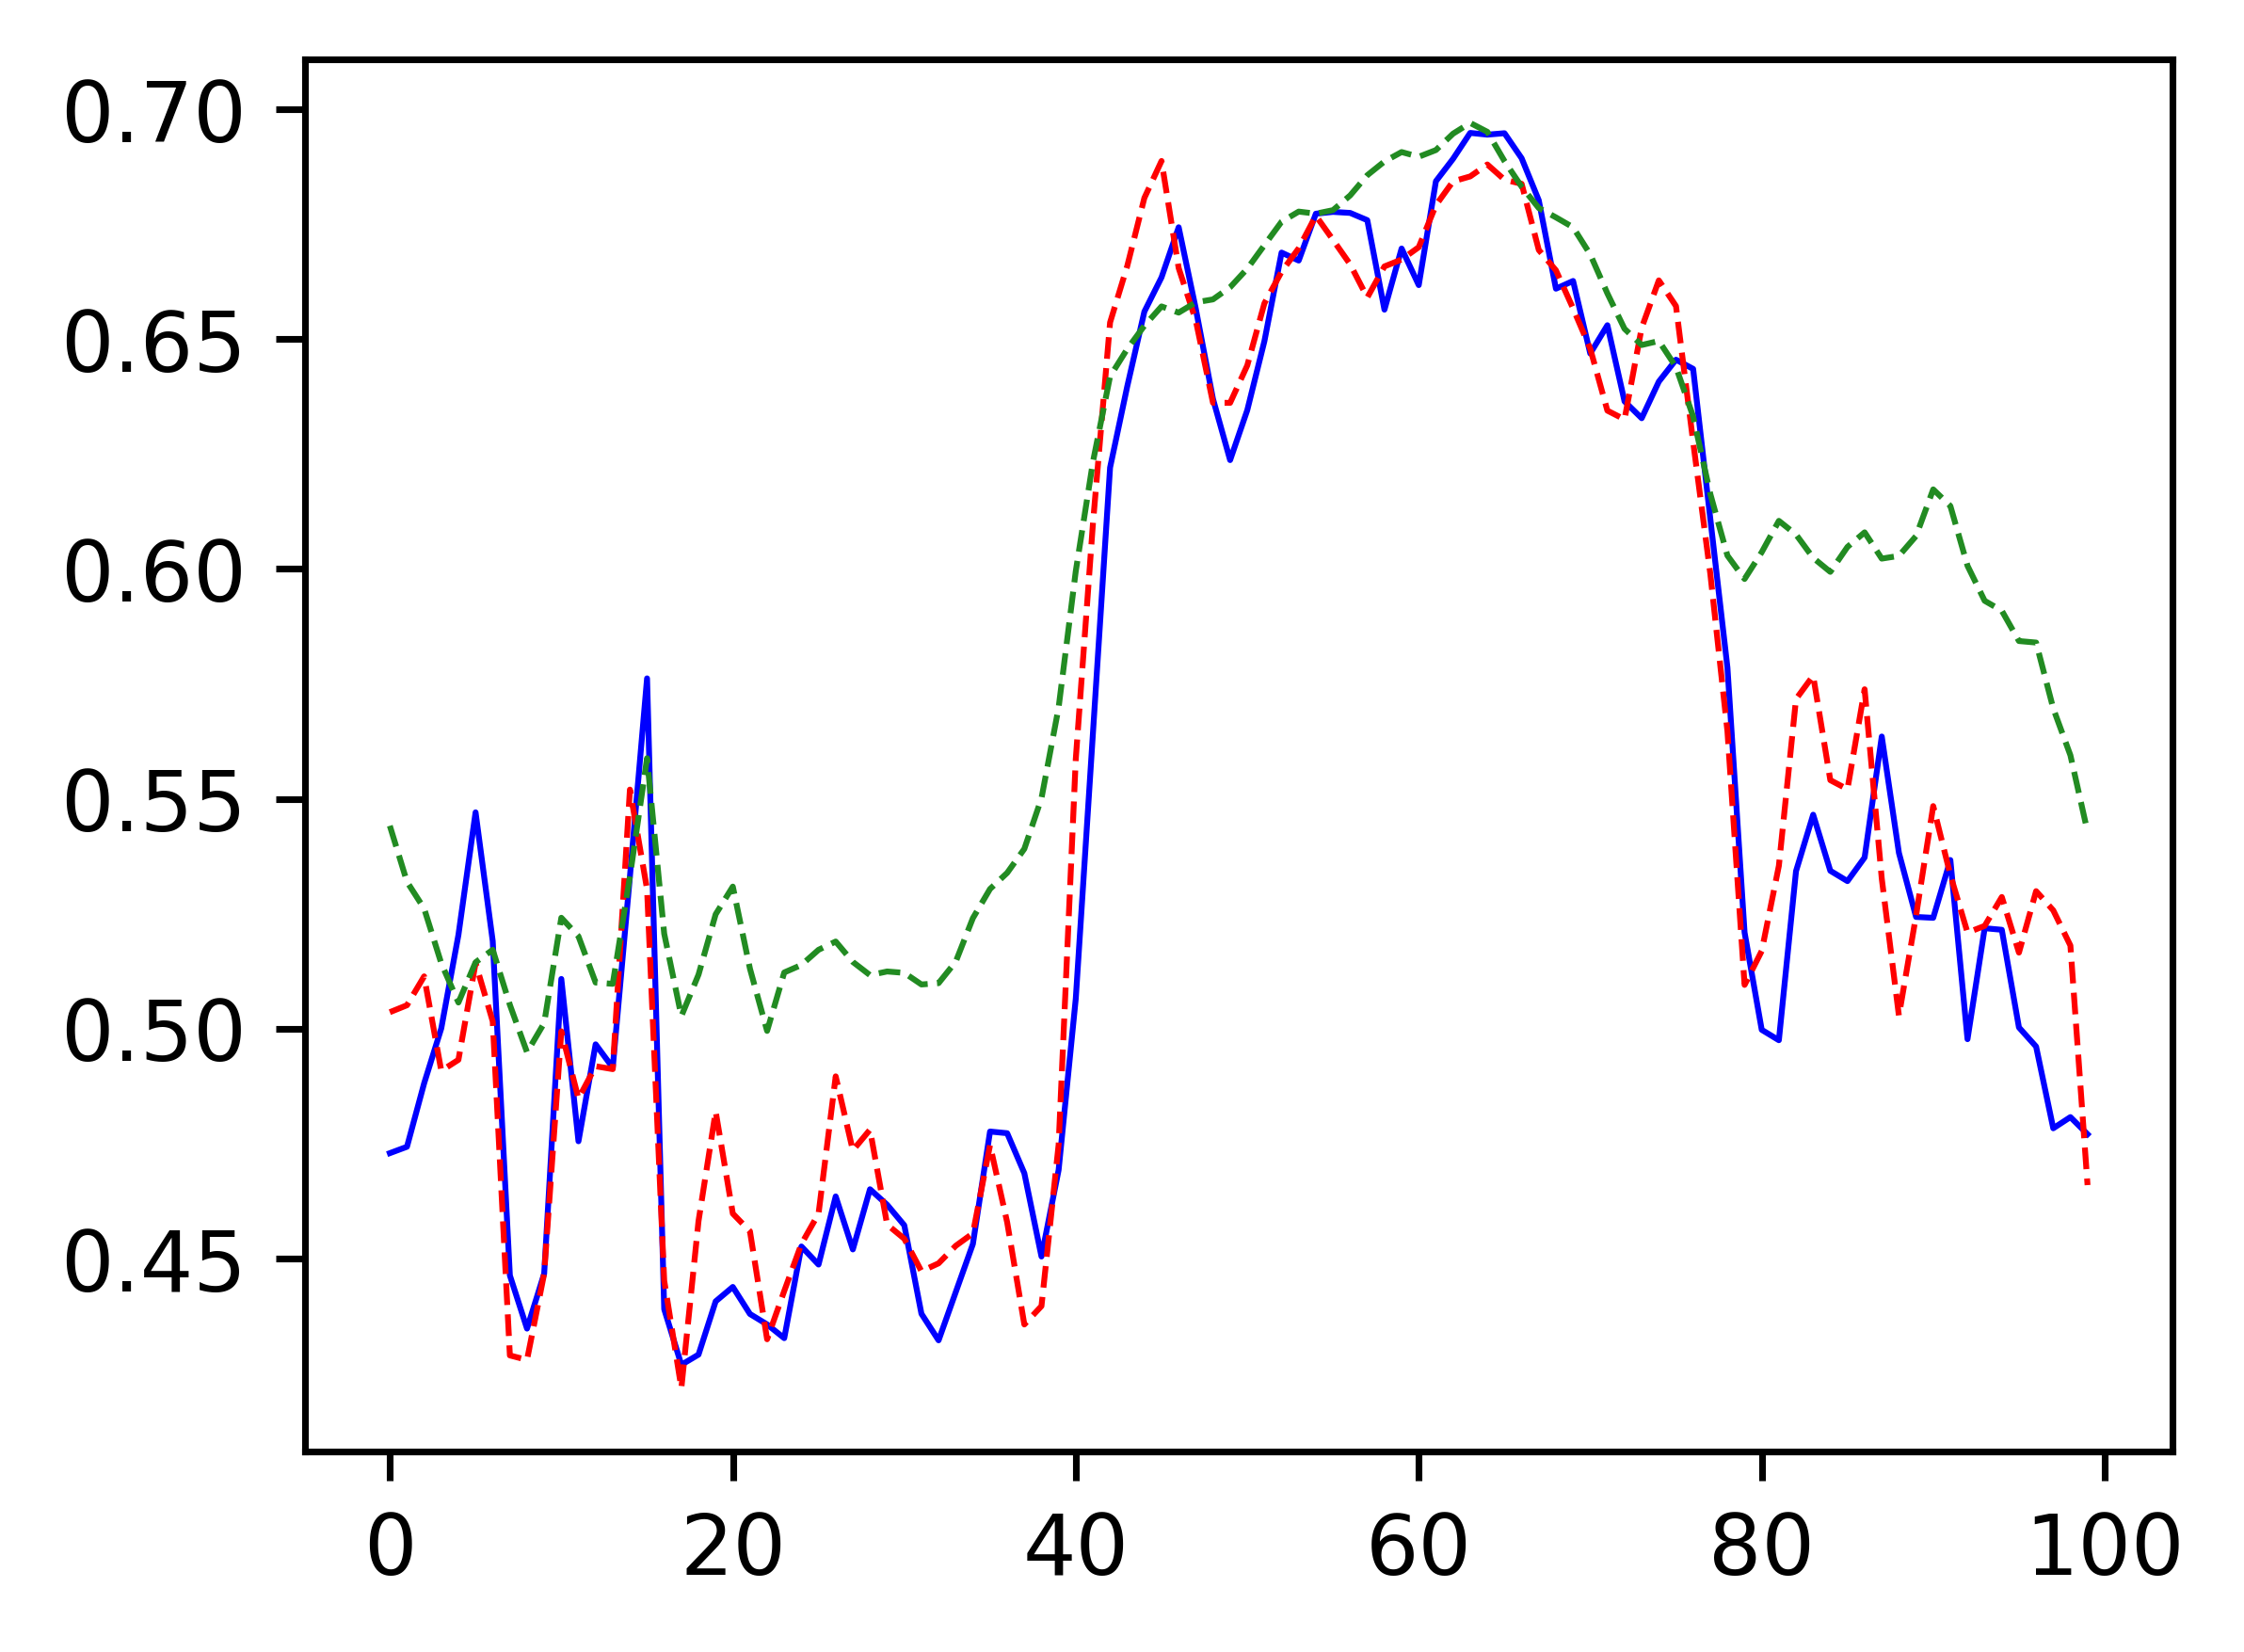

In [33]:
# 颈向基核函数配置支持向量机
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# 训练
svr.fit(train_x, train_y)
# 预测 保存预测结果
svr_y_predict = svr.predict(test_x)
pred_loss = svr_y_predict-test_y
eval_loss = []
for i in range(pred_loss.shape[0]):  
    eval_loss.append(pred_loss[i].item()/test_y[i].item())    #计算误差占真实值y的百分之多少
    
perc = (sum(eval_loss)/len(eval_loss))*100          #平均百分比误差 
print('Percentage error is :', perc)

fig = plt.figure(figsize=(4,3), dpi=640)
plt.plot(test_y[100: 200], color='b', linewidth=0.7)
plt.plot(pred.squeeze(0).detach().cpu().numpy()[100: 200], '--', color='r', linewidth=0.7)
plt.plot(svr_y_predict[100: 200], '--', color='forestgreen', linewidth=0.7)
plt.show()
fig.savefig('./SVM_pred3.pdf')

Percentage error is : 4.918188848783746


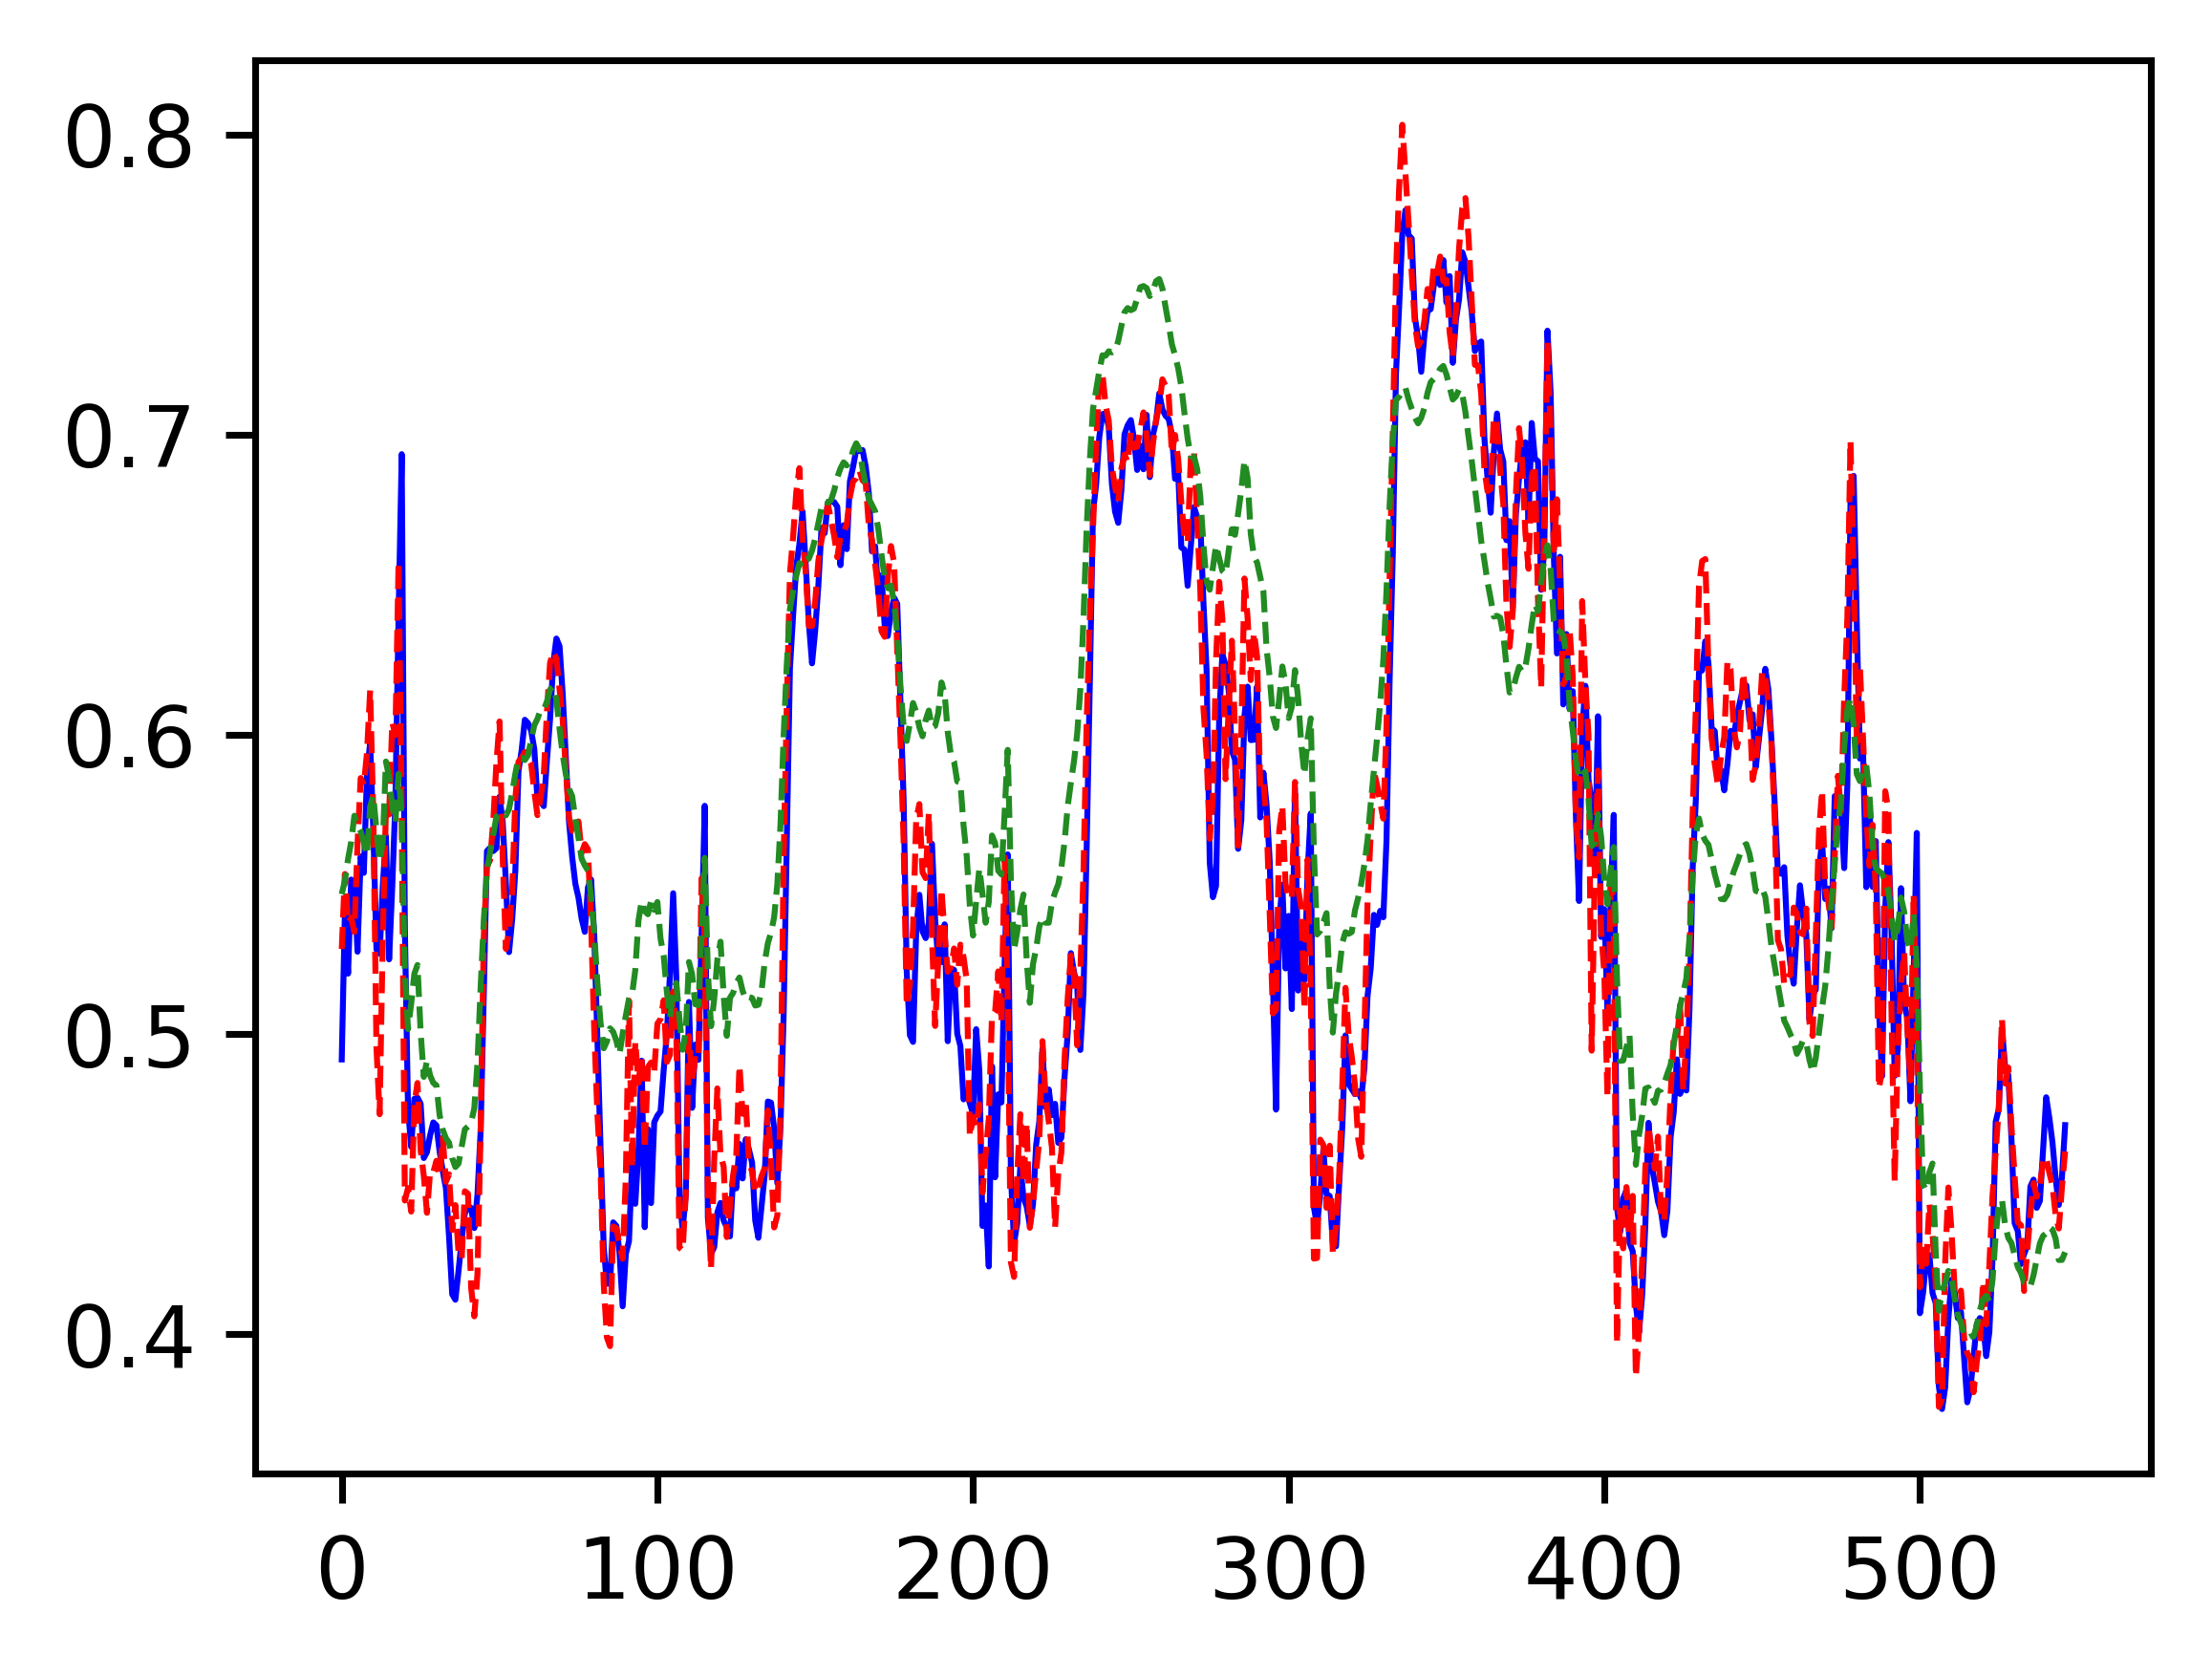

In [36]:
# 颈向基核函数配置支持向量机
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# 训练
svr.fit(train_x, train_y)
# 预测 保存预测结果
svr_y_predict = svr.predict(test_x)
pred_loss = svr_y_predict-test_y
eval_loss = []
for i in range(pred_loss.shape[0]):  
    eval_loss.append(pred_loss[i].item()/test_y[i].item())    #计算误差占真实值y的百分之多少
    
perc = (sum(eval_loss)/len(eval_loss))*100          #平均百分比误差 
print('Percentage error is :', perc)

fig = plt.figure(figsize=(4,3), dpi=640)
plt.plot(test_y, color='b', linewidth=0.7)
plt.plot(pred.squeeze(0).detach().cpu().numpy(), '--', color='r', linewidth=0.7)
plt.plot(svr_y_predict, '--', color='forestgreen', linewidth=0.7)
plt.show()
fig.savefig('./SVM_pred3.pdf')

### Ablation study

Evaluate the contribution of each design in our model via Relative Percentage Difference (RPD)

##### Macro Design

|   |Params(M)|FLOPs(G)|RPD|
|---|---|---|---|
|<b>Baseline|  |   |<b>3.06|
|w/o temp info|  |   |20.5|
|w/o non-temp info|  |   |3.24|

##### Micro Design

|   |Params(M)|FLOPs(G)|RPD|
|---|---|---|---|
|<b>Baseline|  |   |<b>3.06|
|w/o BN  |  |   |4.15|
|w/o DW  |  |   |3.62|
|w/o Conv|  |   |8.56|
|w/o LSTM|  |   |3.69|

##### Nums of hidden layers in the LSTM

|   |Params(M)|FLOPs(G)|RPD|
|---|---|---|---|
|1  |   |   |3.72|
|2  |   |   |3.26|
|<b>3  |   |   |<b>3.06|
|4  |   |   |3.21|

##### Dims of hidden layers in the LSTM

|   |Params(M)|FLOPs(G)|RPD|
|---|---|---|---|
|32  |   |   |4.72|
|64  |   |   |3.69|
|<b>128  |   |   |<b>3.06|
|256 |   |   |4.15|